# Разработка модели для предсказания региона, где добыча нефти принесет наибольшую прибыль

**Краткое описание задачи:**<br>
Построить модель, которая предскажет регион, где добыча нефты принесет наибольшую прибыль.

**План работы:**
1. Разработка модели МО.
    - Изучить входные данные, оценить полноту и качество входных данных для достижения цели исследования. Определить задачи предобработки данных.
    - Осуществить предобработку данных в части улучшение качества данных для дальнейшего анализа.
    - Провести исследовательский анализ данных первого блока, оценить (уточнить) необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования, дополнить ими входные данные, провести корреляционный анализ данных.
    - Подготовить данные к обучению моделей (объединить или разделить необходимые данные в единый дата-сет, сформировать новые признаки, дополнительные категории и групп данных, создать пайплайны).
    - Разработать модели машинного обучения, проанализировать качество разработанных моделей машинного обучения, выбрать лучшую модель МО, оценить важность признаков. Интрепретировать модель.
2. Оценка прибыли и рисков убытков для представленных регионов.
    - Расчет достаточного объёма сырья для безубыточной разработки новой скважины.
    - Разработка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели.
    - Расчет рисков и прибыли для каждого региона.
    
**Критерии качества**

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них необходимо выбирать регион с наибольшей средней прибылью.

## Импорт библиотек

In [2]:
# Импортируем библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    MaxAbsScaler,
    Normalizer
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Объявление констант и установок

In [3]:
RANDOM_STATE = 50

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
TEST_VALID_SIZE = 0.25

## Создание функций

In [6]:
def overview_plot(df):
    """
    Функция, выводящая красивый график (подписанный, с адекватным 
    количеством корзин и гридом) только для числовых столбцов дата-сетов
    в целях предварительного анализа
    
    :param df: Дата-сет для которого проводится анализ
    :return: None # Результат выводится на экран  
    
    """    
     
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    
    for col in num_col_names:
        # Применим правило Квиксола: количество интервалов (bins)
        # близко к квадратному корню из числа наблюдений.
        bins = int(np.round(math.sqrt(len(df[col])), 0))
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        df[col].plot(
            kind='hist',
            bins=bins,
            grid=True,
            legend=False,
            ax=axes[0]
        )
        legend = '[' + col + ']'
        axes[0].set_title(
            'Распределение исследуемого параметра.\nСтолбец ' + legend
        )
        axes[0].set_xlabel(
            'Единицы изменения\nисследуемого параметра'
        )
        axes[0].set_ylabel(
            'Частота повторений\nисследуемого параметра'
        )
        
        df[col].plot(kind='box', grid=True, legend=False, ax=axes[1])
        axes[1].set_title(
            'Диаграмма размаха\nисследуемого параметра.\nСтолбец ' + legend
        )
        axes[1].set_xlabel(
            'Наименование\nисследуемого столбца'
        )
        axes[1].set_ylabel(
            'Единицы изменения\nисследуемого параметра'
        )
        fig.tight_layout()
        plt.show()
    
    if len(num_col_names) == 0: print('В дата-сете нет числовых столбцов')

In [7]:
def overview(df):
    """
    Функция, выводящая несколько элементов предварительного анализа данных
    
    :param df: Дата-сет для которого проводится анализ
    :return: несколько строк для отображения в Jupiter
    
    """    
     
    df.info()
    overview_plot(df)
    return df.sample(5)

In [8]:
def plot_pie(data, axes, legend):
    """
    Функция, выводящая круговую диаграмму в соответствующую figure
    
    :param data: pandas.Series
    :param axes: matplotlib.axes.Axes
    :param legend: str
    :return: None; результат выводится на экран
    
    """    
    
    data.value_counts().plot(
        kind = 'pie', 
        autopct = '%1.0f%%',
        ylabel = '',
        title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
        ax = axes
    )

def analysis_cat_cols(df, columns):
    """
    Функция, выводящая результаты анализа категориальных признаков 
    
    :param df: pandas.DataFrame; Дата-сет для которого проводится анализ
    :param columns: list; Список анализируемых столбцов дата-сета df
    :return: None; результат выводится на экран
    
    """    
    
    col_for_pie = []
    col_for_barh = []
    pie_plot = lambda x: True if x < 5 else False
    for col in columns:
        if pie_plot(df[col].nunique()):
            col_for_pie.append(col)
        else:
            col_for_barh.append(col)
    lenght = len(col_for_pie)
    rows = int(-(-lenght//4))
    if lenght == 1:
        legend = '[' + col_for_pie[0] + ']'
        plot_pie(df[col_for_pie[0]], None, legend)  
    elif rows > 1:
        cols = 4 if ((lenght % 4 != 1) or (lenght % 3 == 1)) else 3    
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i // cols, i % cols], legend)
        for k in range(i+1, cols*rows):
            fig.delaxes(axes[k // cols][k % cols])        
        fig.tight_layout()
    else:
        cols = lenght
        fig, axes = plt.subplots(1, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i % cols], legend)
        fig.tight_layout()
    plt.show()
    
    for i in range(0, len(col_for_barh)):
        legend = '[' + col_for_barh[i] + ']'
        df[col_for_barh[i]].value_counts(ascending=True).plot(
            kind = 'barh', 
            title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
            ylabel = '',
        )   
        plt.xlabel('Количество элементов')
        plt.ylabel('Категория')
        plt.show() 

In [9]:
def my_describe(df, column, desc=['hist', 'QR', 'describe', 'box', 'eject'],
                hist_desc=['Распределение\nисследуемого параметра',
                           'Единицы изменения\nисследуемого параметра',
                           'Частоста повторений\nисследуемого параметра'],
                box_desc=['Диаграмма размаха\nисследуемого параметра',
                           'Наименование\nисследуемого столбца',
                           'Единицы изменения\nисследуемого параметра']):
    """
    Функция, выводящая основные показатели для анализа количественных
    признаков
    
    :param df: pandas.DataFrame; дата-сет для которого проводится анализ
    :param column: str; столбец, для которого проводится анализ
    :param desc: list; способы вывода результатов анализа
    :param hist_desc: list; подписи для гистограммы
    :param box_desc: list; подписи для диаграммы размаха
    :return: None; результат выводится на экран
    
    """        
    
    legend_my_desc = 'Столбец' + ' [' + column + ']'
    
    if 'hist' in desc:
        bins = int(np.round(math.sqrt(len(df[column])), 0))
        df[column].plot(kind='hist', bins=bins, grid=True, legend=True)
        plt.title(hist_desc[0])
        plt.xlabel(hist_desc[1])
        plt.ylabel(hist_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
        
    quartiles = df[column].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    min_diagramm = max(quartiles[0.25] - 1.5*iqr, df[column].min())
    max_diagramm = min(quartiles[0.75] + 1.5*iqr, df[column].max())  
    
    if 'describe' in desc:
        print()
        print('Ключевые характеристики распределения:')
        print(df[column].describe().apply("{0:.2f}".format))

    if 'QR' in desc:
        print()
        print('Ключевые характеристики диграммы размаха:')
        print('IQR\t\t\t{0:.2f}'.format(iqr))
        print('Q1-1,5*IQR\t\t{0:.2f}'.format(quartiles[0.25] - 1.5*iqr))
        print('MIN диаграммы размаха\t{0:.2f}'.format(min_diagramm))
        print('Q3+1,5*IQR\t\t{0:.2f}'.format(quartiles[0.75] + 1.5*iqr))      
        print('MAX диаграммы размаха\t{0:.2f}'.format(max_diagramm))
        print()
        
    if 'box' in desc:
        df[column].plot(kind='box', grid=True, legend=False)
        plt.title(box_desc[0])
        plt.xlabel(box_desc[1])
        plt.ylabel(box_desc[2])
        plt.show()
    
    if 'eject' in desc:
        print('Ключевые характеристики выбросов:')
        print('Количество выбросов (вверх)\t{0:.0f}'
              .format(len(df[df[column] > max_diagramm])))
        print('Доля выбросов (вверх)\t\t{0:.2f}%'
              .format(len(df[df[column] > max_diagramm]) / len(df) * 100))
        print('Количество выбросов (вниз)\t{0:.0f}'
              .format(len(df[df[column] < min_diagramm])))
        print('Доля выбросов (вниз)\t\t{0:.2f}%'
              .format(len(df[df[column] < min_diagramm]) / len(df) * 100))

In [10]:
def is_norm(data):
    """
    Функция, позволяющая оценить нормальность распределения количественной 
    величины
    
    :param data: pandas.Series; распределение, для которого проводится анализ
    :return: None; результат выводится на экран
    
    """        
    
    res = stats.normaltest(data)
    stats.probplot(data, dist='norm', plot=plt)
    plt.show()
    # Коэффициент статистической значимости установим 0.01
    if res.pvalue > 0.01:
        return (
            'p-value = {}. Имеются основания говорить'
            'о нормальности распределения'
            .format(res.pvalue)
        )
    else:
        return (
            'p-value = {}. Имеются основания говорить'
            'о НЕнормальности распределения'
            .format(res.pvalue)
        )

In [11]:
def corr_matrix(df, cols, corr_type, target=None, interval_cols=None):
    """
    Функция, формирующая матрицу корреляции
    
    :param df: pandas.Series; распределение, для которого проводится анализ
    :param cols: list
    :param corr_type: str, 'phik' или 'spearman' или ''
    :param target: str
    :return: None; результат выводится на экран
    
    """        
    
    new_cols = list(cols)
    new_cols.append(target)
    if corr_type == 'phik':
        corr = df[new_cols].phik_matrix(interval_cols=interval_cols)
    else:
        corr = df[new_cols].corr(method=corr_type)
    plt.figure(figsize = (10, 5))
    sns.heatmap(corr, vmin=-1, vmax=1,
                cmap='coolwarm', annot=True, fmt='.2f')
    #plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Матрица корреляции')
    plt.show()

In [12]:
# Функция, отражающая диаграмму рассеяния
def numcat_scatter(df, scatter_type, cols):
    x = cols[0]
    y = cols[1]
    try:
        h = cols[2]
    except:
        h = None
    if scatter_type == 'cat':
        try:
            sns.catplot(data=df, x=x, y=y, hue=h, height=4, aspect=2) 
            plt.title('Распределение признака "{}"\nпо категориям "{}"'.format(x, y))
            plt.xlabel('Признак "{}"'.format(x))
            plt.ylabel('Категория "{}"'.format(y))
            plt.show()
        except Exception as e: print(e)
    elif scatter_type == 'num':
        plt.figure(figsize=(11, 6))
        plt.scatter(x=df[x], y=df[y])
        plt.title('Распределение признака "{}"\nв зависимости от "{}"'.format(x, y))
        plt.xlabel('Признак "{}"'.format(x))
        plt.ylabel('Признак "{}"'.format(y))
        plt.show()
    else:
        print('Wrong scatter_type')

In [13]:
# Деление дата-сета на выборки для обучения
def prepare_split(df, goal, num_col_names, cat_col_names, val=False):
    
    columns_for_model = num_col_names + cat_col_names
    
    X = df[columns_for_model]
    y = df[goal]
    
    if not val:
        # Разобьем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=TEST_VALID_SIZE,
            random_state=RANDOM_STATE
        )
        return X_train, y_train, X_test, y_test
    else:
        train = (1 - TEST_VALID_SIZE*2)
        test = TEST_VALID_SIZE
        val = TEST_VALID_SIZE
        # Разобьем данные на обучающую, тестовую и валидационную выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.25,
            random_state=RANDOM_STATE
        )
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, 
            y_train, 
            test_size=0.25,
            random_state=RANDOM_STATE
        )
        return X_train, y_train, X_test, y_test, X_valid, y_valid

## Разработка модели МО

### Шаг 1. Загрузка и изучение входных данных

In [14]:
data1 = pd.read_csv('../../datasets/geo_data_0.csv', sep=",")
data2 = pd.read_csv('../../datasets/geo_data_1.csv', sep=",")
data3 = pd.read_csv('../../datasets/geo_data_2.csv', sep=",")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


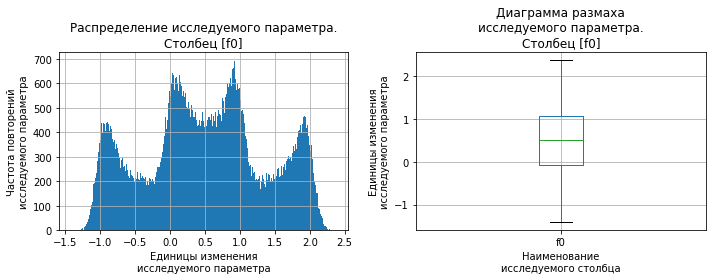

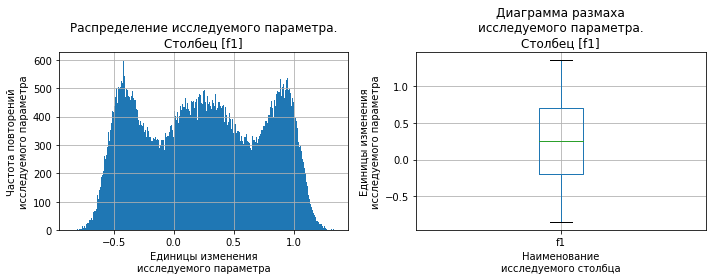

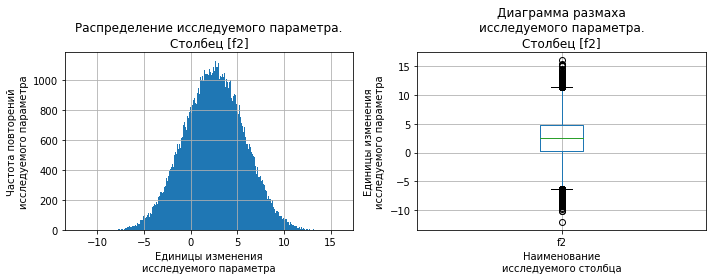

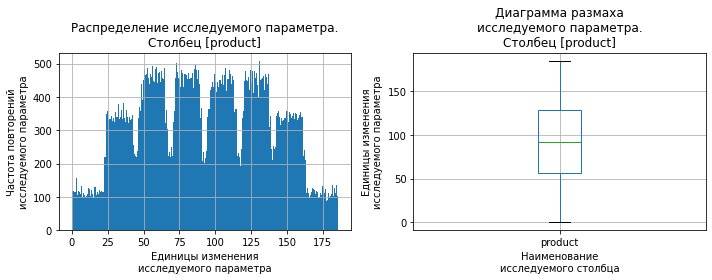

,id,f0,f1,f2,product
36450,v36qR,-0.831713,0.475829,0.588542,79.895025
3680,rjaQp,0.504756,0.876490,-5.754700,10.257482
1663,UkcLx,1.926558,-0.147281,3.910743,81.610323
34152,yrVJX,2.001047,0.046211,-1.708375,94.100488
45651,gzsvS,0.776808,0.592841,4.134436,132.309725


In [15]:
# Изучим общую информацию о данных
overview(data1)

На основании общих сведений о входных данных таблицы `data1` (первый регион) сделаем выводы об их полноте и качестве для целей исследования:

1. Столбец `id` представляет собой ключевой столбец с уникальными наименованиями скважин. Не числовой столбец;
2. В таблице не обнаружены пропуски данных.
3. Проблем с типами данных не обнаружено - входные и целевой признак имеют тип float.
4. В столбце `f2` на диаграмме размаха выявлены выбросы. Необходимо их проанализировать.
5. Необходимо проверить уникальность скважин в регионах. Если обнаружатся дубликаты - решить, что с ними делать.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


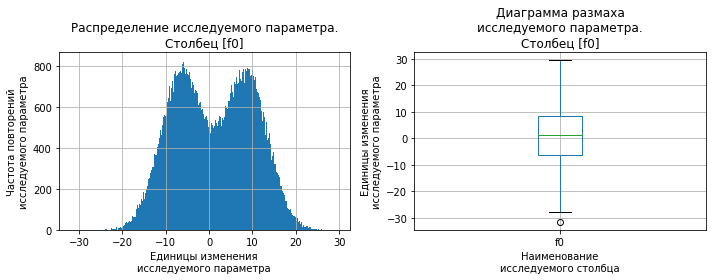

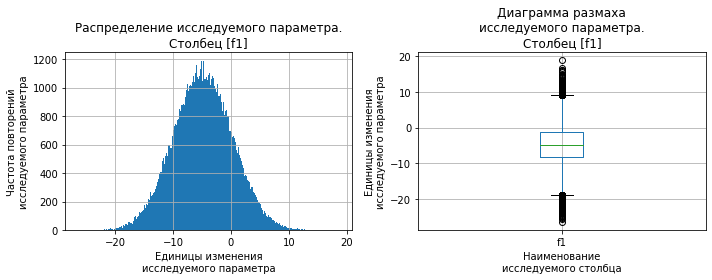

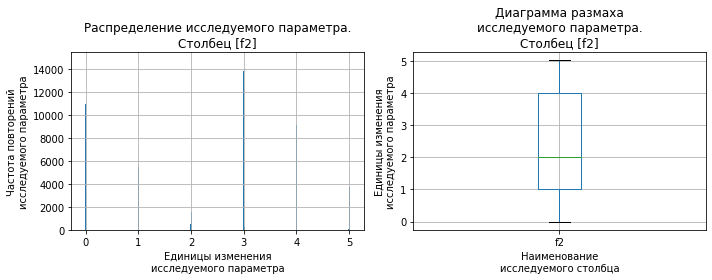

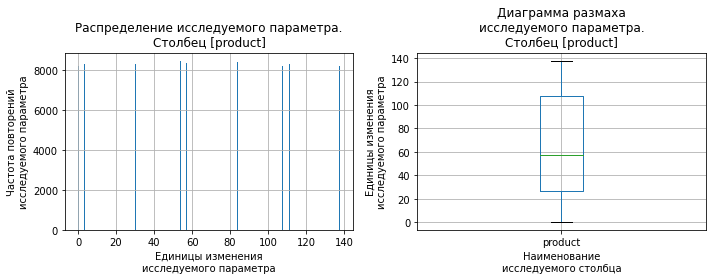

,id,f0,f1,f2,product
65821,xQfZP,8.266903,-1.497127,1.002589,26.953261
32103,POS68,-12.407862,-1.535018,2.996819,84.038886
6590,GprW9,0.499646,1.688751,2.004735,57.085625
8608,PuTUv,20.498532,-4.033406,2.001693,53.906522
12536,QG8sZ,-5.838930,-6.681505,0.001222,3.179103


In [16]:
# Изучим общую информацию о данных
overview(data2)

На основании общих сведений о входных данных таблицы `data2` (второй регион) сделаем выводы об их полноте и качестве для целей исследования:

1. Столбец `id` представляет собой ключевой столбец с уникальными наименованиями скважин. Не числовой столбец;
2. В таблице не обнаружены пропуски данных.
3. Проблем с типами данных не обнаружено - входные и целевой признак имеют тип float.
4. В столбцах `f1` и `f2` на диаграмме размаха выявлены выбросы. Необходимо их проанализировать.
5. Гистограммы столбцов `f1` и `f2` показали высокую дискретность признаков. Необходим дополнительный анализ.
6. Необходимо проверить уникальность скважин в регионах. Если обнаружатся дубликаты - решить, что с ними делать.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


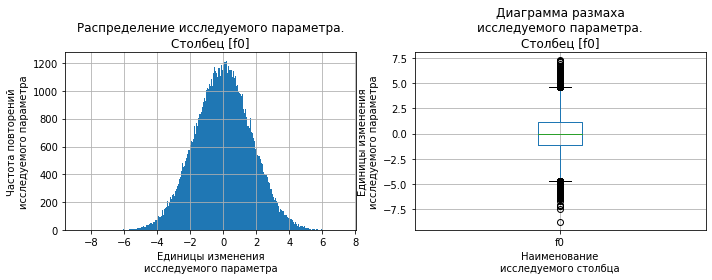

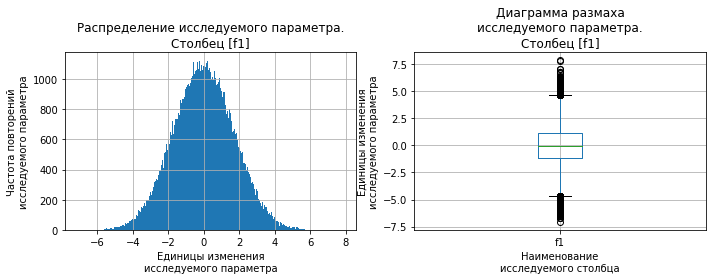

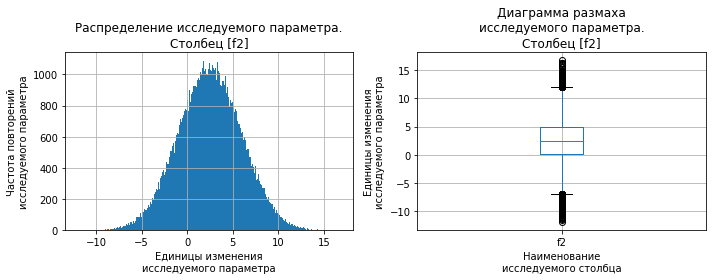

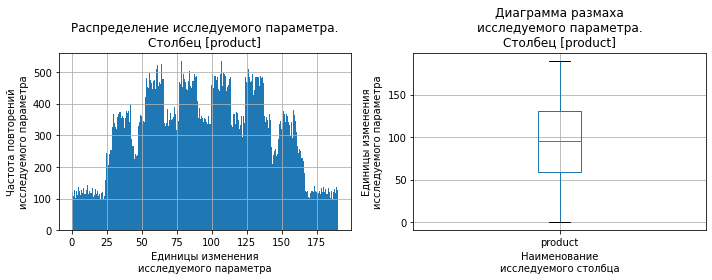

,id,f0,f1,f2,product
64951,D3R9J,1.356174,1.354381,-2.673613,35.614663
88713,9hLbn,-1.438696,-0.229112,-0.368589,88.904997
56226,Y9kPk,-0.780570,-0.676559,-4.799067,71.783585
174,p0QDu,-0.673240,-0.962562,-5.922262,13.913171
91110,Tt5xT,-0.178934,1.180957,4.743339,10.051444


In [17]:
# Изучим общую информацию о данных
overview(data3)

На основании общих сведений о входных данных таблицы `data3` (третий регион) сделаем выводы об их полноте и качестве для целей исследования:

1. Столбец `id` представляет собой ключевой столбец с уникальными наименованиями скважин. Не числовой столбец;
2. В таблице не обнаружены пропуски данных.
3. Проблем с типами данных не обнаружено - входные и целевой признак имеют тип float.
4. В столбцах `f0`, `f1` и `f2` на диаграмме размаха выявлены выбросы. Необходимо их проанализировать.
5. Необходимо проверить уникальность скважин в регионах. Если обнаружатся дубликаты - решить, что с ними делать.

#### Вывод по разделу "Загрузка и изучение входных данных"

В ходе изучения входных данных были сделаны следующие выводы.

1. Столбец "id" всех таблицах представляет ключевой столбец с уникальными наименованиями скважин. Не числовой столбец. Необходимо проверить уникальность скважин в регионах. Если обнаружатся дубликаты - решить, что с ними делать.
2. В таблицах не обнаружены пропуски данных.
3. Проблем с типами данных не обнаружено - входные и целевой признак имеют тип float.
4. В столбцах `f0`, `f1` и `f2` на диаграммах размаха выявлены выбросы. Необходимо их проанализировать.
5. Гистограммы столбцов `f1` и `f2` таблицы `data1` показали высокую дискретность признаков. Необходим дополнительный анализ.

### Шаг 2. Предобработка данных

Прозведем предобработку данных на основании ранее сделанных выводов - проверим наличие дубликатов в данных.

Предварительно создадим копии входных данных для дальнейшей работы.

In [18]:
c_data1 = data1.copy()
c_data2 = data2.copy()
c_data3 = data3.copy()

#### Обработка дубликатов

Проверим наличие дубликатов в столбцах `id` в таблицах, а также наличие полных дубликатов 

In [19]:
c_data1.duplicated(subset=['id']).sum()

10

In [20]:
c_data2.duplicated(subset=['id']).sum()

4

In [21]:
c_data3.duplicated(subset=['id']).sum()

4

Выявлены дубликаты по столбцу `id` в каждой таблице. Изучим их.

In [22]:
c_data1[c_data1.duplicated(subset=['id'], keep=False)].head(10)

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [23]:
c_data2[c_data2.duplicated(subset=['id'], keep=False)].head(10)

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [24]:
c_data3[c_data3.duplicated(subset=['id'], keep=False)].head(10)

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Несколько скваждин продублированы с различными показателями. Мы не знаем, какие показатели правильные. Без эксперта в предметной области разобраться нельзя. Количество дубликатов очень мало. Удалим все записи.

In [25]:
c_data1 = c_data1.drop_duplicates(subset=['id'], keep=False)
c_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [26]:
c_data2 = c_data2.drop_duplicates(subset=['id'], keep=False)
c_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [27]:
c_data3 = c_data3.drop_duplicates(subset=['id'], keep=False)
c_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99992 non-null  object 
 1   f0       99992 non-null  float64
 2   f1       99992 non-null  float64
 3   f2       99992 non-null  float64
 4   product  99992 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [28]:
c_data1.duplicated().sum()

0

In [29]:
c_data2.duplicated().sum()

0

In [30]:
c_data3.duplicated().sum()

0

Полных дубликатов не выявлено.

#### Вывод по разделу "Предобработка данных"

В ходе предобработки данных были достигнуты следующие результаты:

1. Были обнаружены дубликаты по столбцу `id`. Несколько скваждин продублированы с различными показателями. Мы не знаем, какие показатели правильные. Количество дубликатов очень мало. При этом, такие дубликаты найдены во всех таблицах. Все записи были удалены.

Предобработка данных завершена, данные готовы к дальнейшей анализу и очистке.

### Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение категориальных признаков, применимость признаков для дальнейшей работы (достаточное распределение элементов по признакам - репрезентативность). В то же время, категориальных признаков в данных не обнаружено. При этом, необходимо проверить столбцы `f1` и `f2` таблицы `data2`.
2. Распределение количественных признаков, в том числе, тип распределений для дальнейшей работы по разработке моделей машинного обучения, наличие выбросов и аномальных значений.

Для каждого столбца с количественным параметром:
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемые столбцы с количественным параметром:
- `f0` всех таблиц;
- `f1` всех таблиц;
- `f2` всех таблиц;
- `product` всех таблиц;
    
Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для количетсвенных признаков в соответствии с описанным выше подходом

#### Столбцы `f0`, `f1`, `f2`, `product` таблицы `c_data1` - первый регион

В рассматриваемых столбцах представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции.

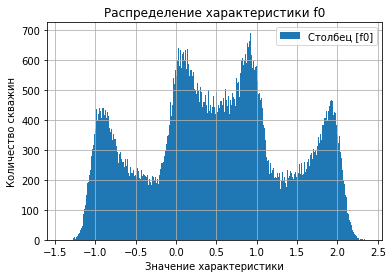


Ключевые характеристики распределения:
count    99980.00
mean         0.50
std          0.87
min         -1.41
25%         -0.07
50%          0.50
75%          1.07
max          2.36
Name: f0, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1.15
Q1-1,5*IQR		-1.79
MIN диаграммы размаха	-1.41
Q3+1,5*IQR		2.79
MAX диаграммы размаха	2.36



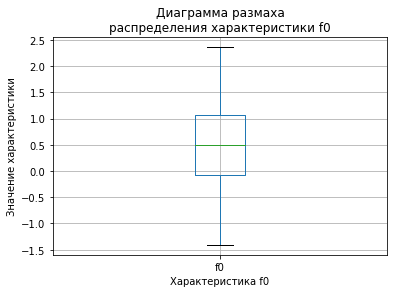

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [31]:
my_describe(
    c_data1, 'f0',
    hist_desc=[
        'Распределение характеристики f0',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f0',
        'Характеристика f0',
        'Значение характеристики'
    ]
)

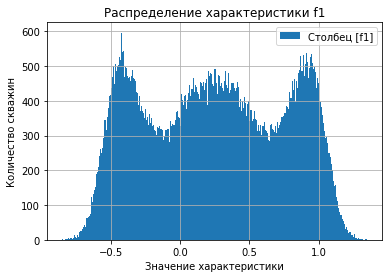


Ключевые характеристики распределения:
count    99980.00
mean         0.25
std          0.50
min         -0.85
25%         -0.20
50%          0.25
75%          0.70
max          1.34
Name: f1, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.90
Q1-1,5*IQR		-1.55
MIN диаграммы размаха	-0.85
Q3+1,5*IQR		2.05
MAX диаграммы размаха	1.34



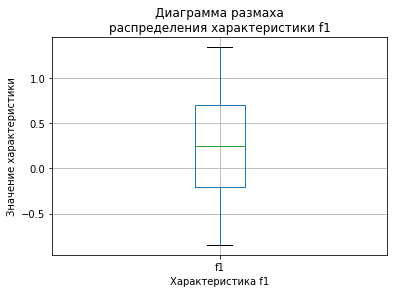

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [32]:
my_describe(
    c_data1, 'f1',
    hist_desc=[
        'Распределение характеристики f1',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f1',
        'Характеристика f1',
        'Значение характеристики'
    ]
)

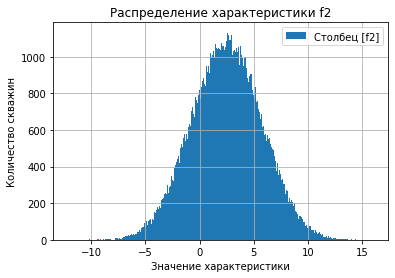


Ключевые характеристики распределения:
count    99980.00
mean         2.50
std          3.25
min        -12.09
25%          0.29
50%          2.52
75%          4.71
max         16.00
Name: f2, dtype: object

Ключевые характеристики диграммы размаха:
IQR			4.43
Q1-1,5*IQR		-6.35
MIN диаграммы размаха	-6.35
Q3+1,5*IQR		11.36
MAX диаграммы размаха	11.36



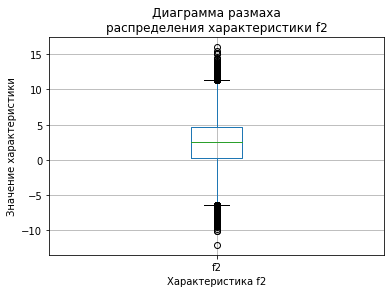

Ключевые характеристики выбросов:
Количество выбросов (вверх)	248
Доля выбросов (вверх)		0.25%
Количество выбросов (вниз)	259
Доля выбросов (вниз)		0.26%


In [33]:
my_describe(
    c_data1, 'f2',
    hist_desc=[
        'Распределение характеристики f2',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f2',
        'Характеристика f2',
        'Значение характеристики'
    ]
)

В распределении характеристики выявлено небольшое количество выбросов - не более 0,51%. Оценить критичность этих выбросов не удастся без консультации экспертов в указанной области. Удалять эти выбросы не будем.

Проверим нормальность единственного распределения, визуально похожего на нормальное.

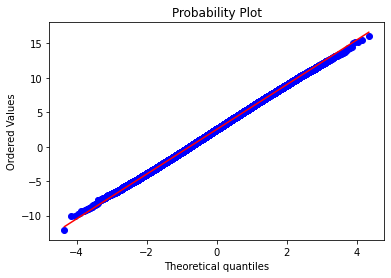

'p-value = 2.8120572527781e-13. Имеются основания говоритьо НЕнормальности распределения'

In [34]:
is_norm(c_data1['f2'])

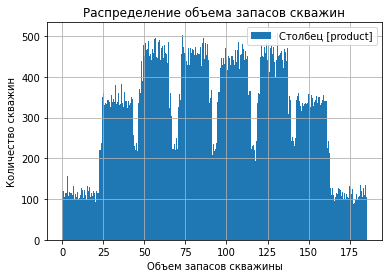


Ключевые характеристики распределения:
count    99980.00
mean        92.50
std         44.29
min          0.00
25%         56.50
50%         91.85
75%        128.56
max        185.36
Name: product, dtype: object

Ключевые характеристики диграммы размаха:
IQR			72.07
Q1-1,5*IQR		-51.60
MIN диаграммы размаха	0.00
Q3+1,5*IQR		236.67
MAX диаграммы размаха	185.36



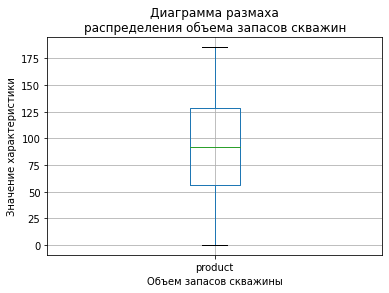

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [35]:
my_describe(
    c_data1, 'product',
    hist_desc=[
        'Распределение объема запасов скважин',
        'Объем запасов скважины',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения объема запасов скважин',
        'Объем запасов скважины',
        'Значение характеристики'
    ]
)

Визуализируем данные для презентации

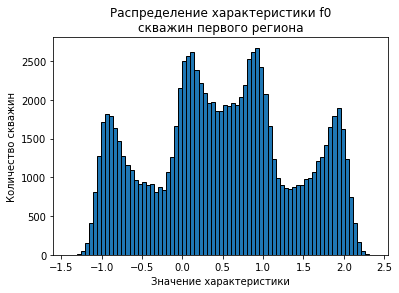

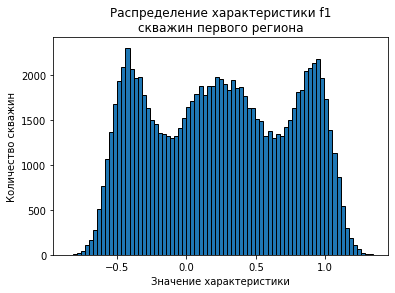

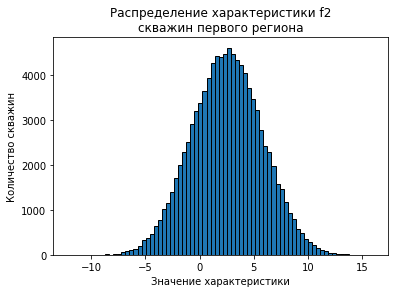

In [36]:
for item in ['f0','f1','f2']:
    plt.hist(c_data1[item], edgecolor='black', bins=75)
    plt.title(f'Распределение характеристики {item}\nскважин первого региона')
    plt.xlabel('Значение характеристики')
    plt.ylabel('Количество скважин')
    plt.show()

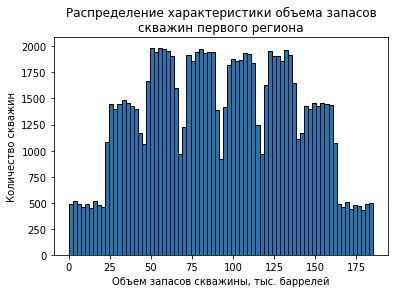

In [37]:
plt.hist(c_data1['product'], edgecolor='black', bins=75)
plt.title(f'Распределение характеристики объема запасов\nскважин первого региона')
plt.xlabel('Объем запасов скважины, тыс. баррелей')
plt.ylabel('Количество скважин')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения характеристик и объема запасов скважин первого региона:

- _характеристика f0:_
    * среднее и медиана равны - 0.50;
    * характеристика 50% скважин в диапазоне -0.07 - 1.07;
    * минимальное значение - -1.41, максимальное - 2.36.

    Выбросы не выявлены.

- _характеристика f1:_
    * среднее и медиана равны - 0.25;
    * характеристика 50% скважин в диапазоне -0.20 - 0.70;
    * минимальное значение - -0.85, максимальное - 1.34.

    Выбросы не выявлены.

- _характеристика f2:_
    * среднее и медиана близки - 2.50 и 2.52;
    * характеристика 50% скважин в диапазоне -0.29 - 4.71;
    * минимальное значение - -12.09, максимальное - 16.00.
    
    Выявлены выбросы (не более 0.51%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.

- _объем запасов:_
    * среднее и медиана близки - 92.50 и 91.84;
    * объем запасов 50% скважин в диапазоне 56.57 - 128.51;
    * минимальное значение - 0.00, максимальное - 185.36.
    
    Выбросы не выявлены.
        
Распределение характеристик визуально не могут быть отнесены к нормальным. Имеются основания говорить, что распределение характеристики f2 не нормально.

Распределение объема запасов визуально представляет равномерное распределение по различным диапазонам объема запасов.

#### Столбцы `f0`, `f1`, `f2`, `product` таблицы `c_data2` - второй регион

В рассматриваемых столбцах представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции.

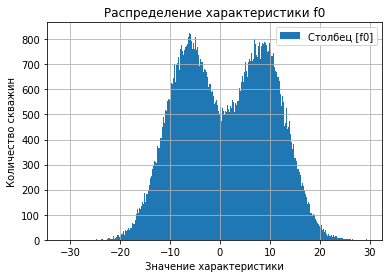


Ключевые характеристики распределения:
count    99992.00
mean         1.14
std          8.97
min        -31.61
25%         -6.30
50%          1.15
75%          8.62
max         29.42
Name: f0, dtype: object

Ключевые характеристики диграммы размаха:
IQR			14.92
Q1-1,5*IQR		-28.68
MIN диаграммы размаха	-28.68
Q3+1,5*IQR		31.00
MAX диаграммы размаха	29.42



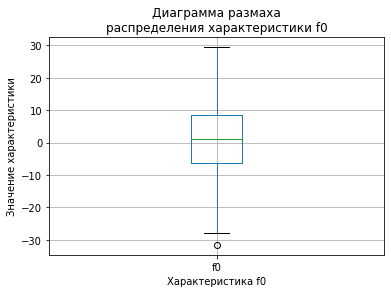

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	1
Доля выбросов (вниз)		0.00%


In [38]:
my_describe(
    c_data2, 'f0',
    hist_desc=[
        'Распределение характеристики f0',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f0',
        'Характеристика f0',
        'Значение характеристики'
    ]
)

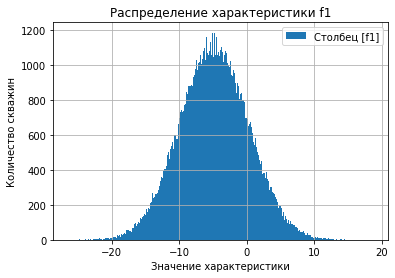


Ключевые характеристики распределения:
count    99992.00
mean        -4.80
std          5.12
min        -26.36
25%         -8.27
50%         -4.81
75%         -1.33
max         18.73
Name: f1, dtype: object

Ключевые характеристики диграммы размаха:
IQR			6.94
Q1-1,5*IQR		-18.67
MIN диаграммы размаха	-18.67
Q3+1,5*IQR		9.07
MAX диаграммы размаха	9.07



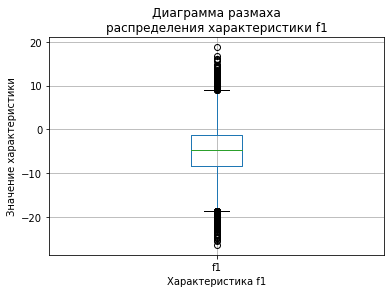

Ключевые характеристики выбросов:
Количество выбросов (вверх)	339
Доля выбросов (вверх)		0.34%
Количество выбросов (вниз)	297
Доля выбросов (вниз)		0.30%


In [39]:
my_describe(
    c_data2, 'f1',
    hist_desc=[
        'Распределение характеристики f1',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f1',
        'Характеристика f1',
        'Значение характеристики'
    ]
)

В распределении характеристики выявлено небольшое количество выбросов - не более 0.64%. Оценить критичность этих выбросов не удастся без консультации экспертов в указанной области. Удалять эти выбросы не будем.

Проверим нормальность единственного распределения, визуально похожего на нормальное.

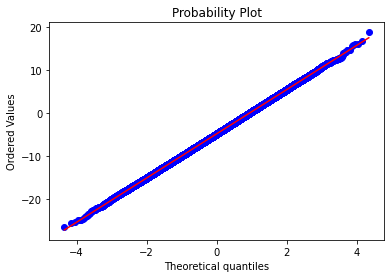

'p-value = 0.03295141201196093. Имеются основания говоритьо нормальности распределения'

In [40]:
is_norm(c_data2['f1'])

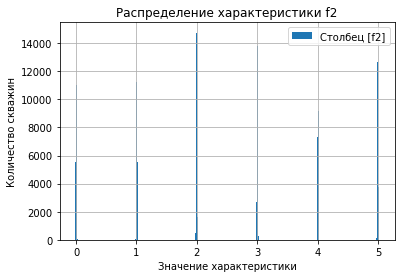


Ключевые характеристики распределения:
count    99992.00
mean         2.49
std          1.70
min         -0.02
25%          1.00
50%          2.01
75%          4.00
max          5.02
Name: f2, dtype: object

Ключевые характеристики диграммы размаха:
IQR			3.00
Q1-1,5*IQR		-3.50
MIN диаграммы размаха	-0.02
Q3+1,5*IQR		8.50
MAX диаграммы размаха	5.02



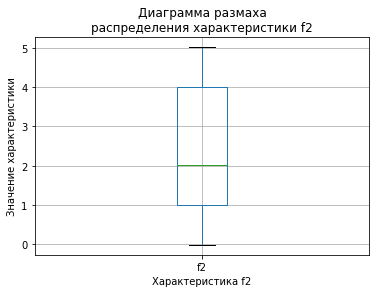

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [41]:
my_describe(
    c_data2, 'f2',
    hist_desc=[
        'Распределение характеристики f2',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f2',
        'Характеристика f2',
        'Значение характеристики'
    ]
)

Распределение визуально похоже на дискретное равномерное. Попробуем определить количество уникальных значений.

In [42]:
len(c_data2['f2'].unique())

99992

Много значений. Вероятно, они распределяеются вокруг ключевых значений. Округлим их.

In [43]:
result = c_data2['f2'].apply(round)

In [44]:
len(result.unique())

6

Так и оказалось. Выведем уникальные значения, вокруг которых сосредоточна характеристика f2.

In [45]:
result.unique()

array([0, 1, 5, 3, 4, 2])

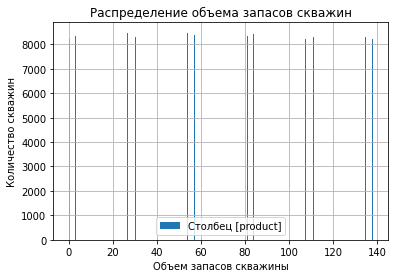


Ключевые характеристики распределения:
count    99992.00
mean        68.82
std         45.94
min          0.00
25%         26.95
50%         57.09
75%        107.81
max        137.95
Name: product, dtype: object

Ключевые характеристики диграммы размаха:
IQR			80.86
Q1-1,5*IQR		-94.34
MIN диаграммы размаха	0.00
Q3+1,5*IQR		229.10
MAX диаграммы размаха	137.95



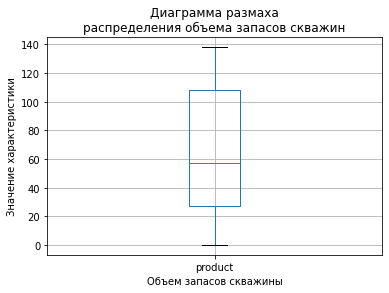

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [46]:
my_describe(
    c_data2, 'product',
    hist_desc=[
        'Распределение объема запасов скважин',
        'Объем запасов скважины',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения объема запасов скважин',
        'Объем запасов скважины',
        'Значение характеристики'
    ]
)

Распределение также визуально похоже на дискретное равномерное. Попробуем определить количество уникальных значений.

In [47]:
len(c_data2['product'].unique())

12

Совсем немного, выведем их

In [48]:
c_data2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Можно предположить сильную зависимость столбца `product` от характеристики `f2`. Проведем позже корреляционный анализ.

Визуализируем данные для презентации

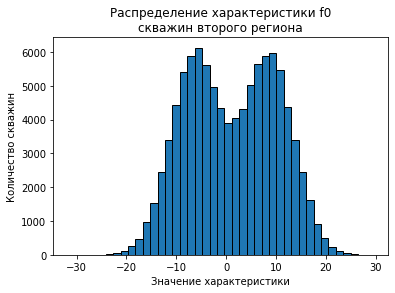

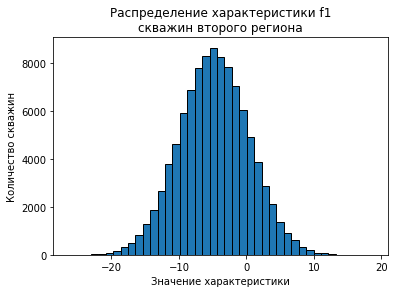

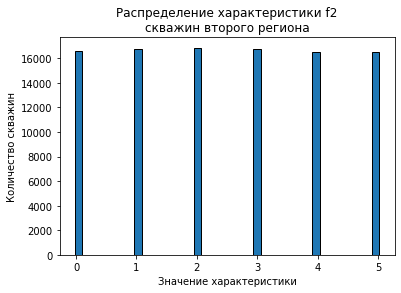

In [49]:
for item in ['f0','f1','f2']:
    plt.hist(c_data2[item], edgecolor='black', bins=41)
    plt.title(f'Распределение характеристики {item}\nскважин второго региона')
    plt.xlabel('Значение характеристики')
    plt.ylabel('Количество скважин')
    plt.show()

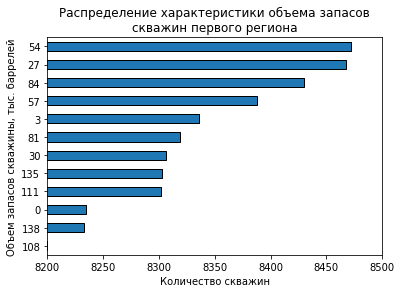

In [50]:
c_data2['product'].apply(round).value_counts(ascending=True).plot(
        kind = 'barh', 
        edgecolor='black',
        rot=0
    )   
plt.title('Распределение характеристики объема запасов\nскважин первого региона')
plt.ylabel('Объем запасов скважины, тыс. баррелей')
plt.xlabel('Количество скважин')
plt.xlim(8200, 8500)
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения характеристик и объема запасов скважин второго региона:

- _характеристика f0:_
    * среднее и медиана близки - 1.14 и 1.15;
    * характеристика 50% скважин в диапазоне -6.30 - 8.62;
    * минимальное значение - -31.61, максимальное - 29.42.

    Выбросы не выявлены.
    
- _характеристика f1:_
    * среднее и медиана близки - -4.80 т -4.81;
    * характеристика 50% скважин в диапазоне -8.27 - -1.33;
    * минимальное значение - -26.36, максимальное - 18.73.

    Выявлены выбросы (не более 0.64%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.

- _характеристика f2:_
    * среднее и медиана различны - 2.49 и 2.01;
    * характеристика 50% скважин в диапазоне 1.00 - 4.00;
    * минимальное значение - -0.02, максимальное - 5.02.
    
   Выявлено, что характеристика имеет равномерное распределение в окрестностях конкретных диапазонах (шесть значений: 0, 1, 2, 3, 4, 5). В связи с этим оценивать среднее и медиану, а также искать выбросы нецелесообразно. Указанная характеристика, вероятно, очень сильно влияет на объем запасов. Оценим влияние при корреляционном анализе.
    
        
Распределение характеристик f0, f2 и объемов запасов product визуально не могут быть отнесены к нормальным. При этом, имеются основания говорить, что распределение характеристики f1 нормально.
    
- _объем запасов_: 
    Выявлено, что характеристика имеет равномерное распределение только по двенадцати конкретных значениям. В связи с этим оценивать среднее и медиану, а также искать выбросы нецелесообразно. Указанная характеристика, вероятно, очень сильно влияет на объем запасов. Оценим влияние при корреляционном анализе.

Распределение объема запасов визуально представляет равномерное распределение по двенадцати конкретным значениям.

#### Столбцы `f0`, `f1`, `f2`, `product` таблицы `c_data3` - третий регион

В рассматриваемых столбцах представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции.

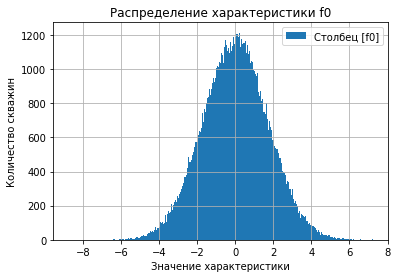


Ключевые характеристики распределения:
count    99992.00
mean         0.00
std          1.73
min         -8.76
25%         -1.16
50%          0.01
75%          1.16
max          7.24
Name: f0, dtype: object

Ключевые характеристики диграммы размаха:
IQR			2.32
Q1-1,5*IQR		-4.64
MIN диаграммы размаха	-4.64
Q3+1,5*IQR		4.64
MAX диаграммы размаха	4.64



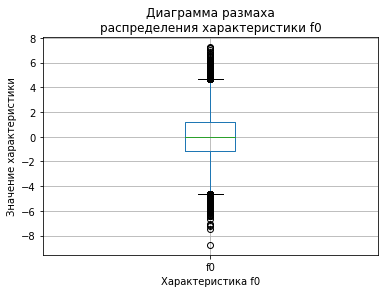

Ключевые характеристики выбросов:
Количество выбросов (вверх)	385
Доля выбросов (вверх)		0.39%
Количество выбросов (вниз)	348
Доля выбросов (вниз)		0.35%


In [51]:
my_describe(
    c_data3, 'f0',
    hist_desc=[
        'Распределение характеристики f0',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f0',
        'Характеристика f0',
        'Значение характеристики'
    ]
)

В распределении характеристики выявлено небольшое количество выбросов - не более 0.74%. Оценить критичность этих выбросов не удастся без консультации экспертов в указанной области. Удалять эти выбросы не будем.

Проверим нормальность распределения, визуально похожего на нормальное.

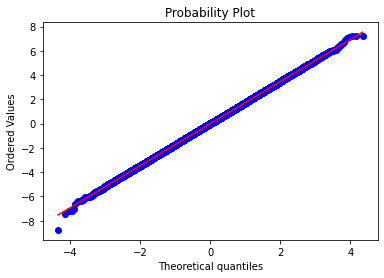

'p-value = 0.5347782522332626. Имеются основания говоритьо нормальности распределения'

In [52]:
is_norm(c_data3['f0'])

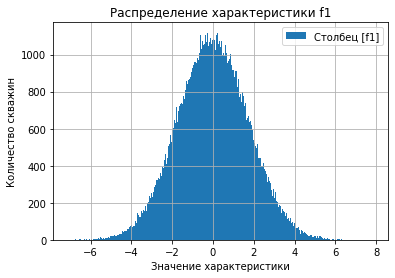


Ключевые характеристики распределения:
count    99992.00
mean        -0.00
std          1.73
min         -7.08
25%         -1.17
50%         -0.01
75%          1.16
max          7.84
Name: f1, dtype: object

Ключевые характеристики диграммы размаха:
IQR			2.34
Q1-1,5*IQR		-4.68
MIN диаграммы размаха	-4.68
Q3+1,5*IQR		4.67
MAX диаграммы размаха	4.67



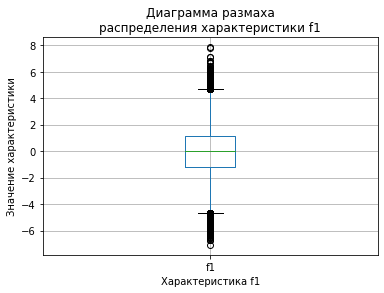

Ключевые характеристики выбросов:
Количество выбросов (вверх)	349
Доля выбросов (вверх)		0.35%
Количество выбросов (вниз)	335
Доля выбросов (вниз)		0.34%


In [53]:
my_describe(
    c_data3, 'f1',
    hist_desc=[
        'Распределение характеристики f1',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f1',
        'Характеристика f1',
        'Значение характеристики'
    ]
)

В распределении характеристики выявлено небольшое количество выбросов - не более 0.69%. Оценить критичность этих выбросов не удастся без консультации экспертов в указанной области. Удалять эти выбросы не будем.

Проверим нормальность распределения, визуально похожего на нормальное.

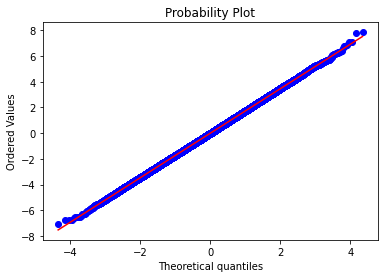

'p-value = 0.11842508751713152. Имеются основания говоритьо нормальности распределения'

In [54]:
is_norm(c_data3['f1'])

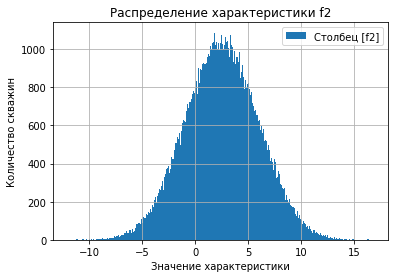


Ключевые характеристики распределения:
count    99992.00
mean         2.50
std          3.47
min        -11.97
25%          0.13
50%          2.48
75%          4.86
max         16.74
Name: f2, dtype: object

Ключевые характеристики диграммы размаха:
IQR			4.73
Q1-1,5*IQR		-6.96
MIN диаграммы размаха	-6.96
Q3+1,5*IQR		11.95
MAX диаграммы размаха	11.95



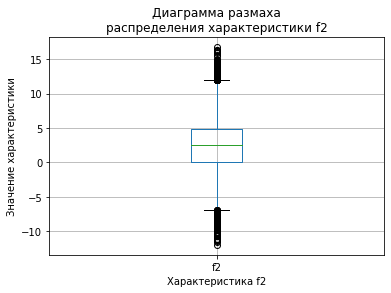

Ключевые характеристики выбросов:
Количество выбросов (вверх)	283
Доля выбросов (вверх)		0.28%
Количество выбросов (вниз)	301
Доля выбросов (вниз)		0.30%


In [55]:
my_describe(
    c_data3, 'f2',
    hist_desc=[
        'Распределение характеристики f2',
        'Значение характеристики',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения характеристики f2',
        'Характеристика f2',
        'Значение характеристики'
    ]
)

В распределении характеристики выявлено небольшое количество выбросов - не более 0.58%. Оценить критичность этих выбросов не удастся без консультации экспертов в указанной области. Удалять эти выбросы не будем.

Проверим нормальность распределения, визуально похожего на нормальное.

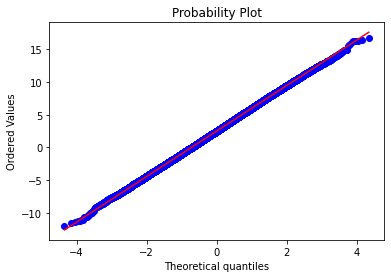

'p-value = 2.8821581805839963e-05. Имеются основания говоритьо НЕнормальности распределения'

In [56]:
is_norm(c_data3['f2'])

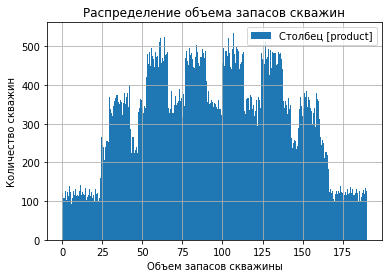


Ключевые характеристики распределения:
count    99992.00
mean        95.00
std         44.75
min          0.00
25%         59.45
50%         94.93
75%        130.59
max        190.03
Name: product, dtype: object

Ключевые характеристики диграммы размаха:
IQR			71.14
Q1-1,5*IQR		-47.25
MIN диаграммы размаха	0.00
Q3+1,5*IQR		237.29
MAX диаграммы размаха	190.03



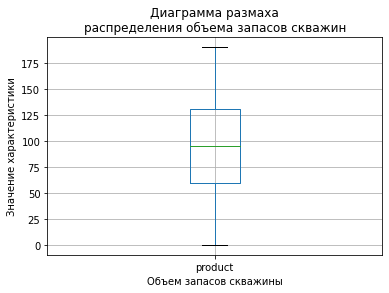

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [57]:
my_describe(
    c_data3, 'product',
    hist_desc=[
        'Распределение объема запасов скважин',
        'Объем запасов скважины',
        'Количество скважин'
    ],
    box_desc=[
        'Диаграмма размаха\nраспределения объема запасов скважин',
        'Объем запасов скважины',
        'Значение характеристики'
    ]
)

Визуализируем данные для презентации

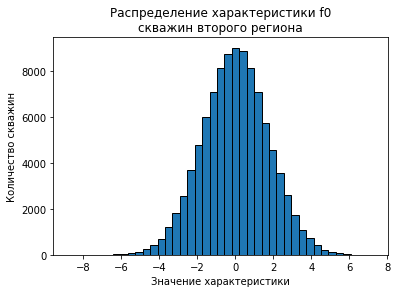

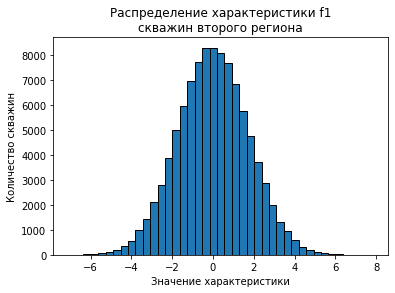

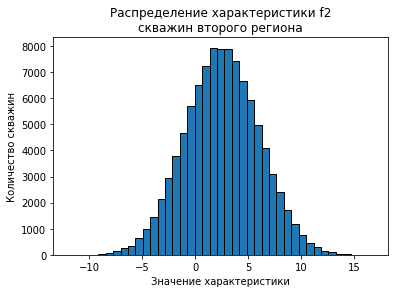

In [58]:
for item in ['f0','f1','f2']:
    plt.hist(c_data3[item], edgecolor='black', bins=41)
    plt.title(f'Распределение характеристики {item}\nскважин второго региона')
    plt.xlabel('Значение характеристики')
    plt.ylabel('Количество скважин')
    plt.show()

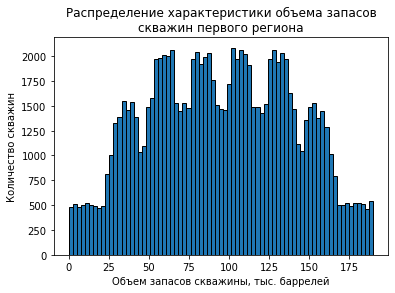

In [59]:
plt.hist(c_data3['product'], edgecolor='black', bins=75)
plt.title(f'Распределение характеристики объема запасов\nскважин первого региона')
plt.xlabel('Объем запасов скважины, тыс. баррелей')
plt.ylabel('Количество скважин')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения характеристик и объема запасов скважин второго региона:

- _характеристика f0:_
    * среднее и медиана близки - 0.00 и 0.01;
    * характеристика 50% скважин в диапазоне -1.16 - 1.16;
    * минимальное значение - -8.76, максимальное - 7.24.

    Выявлены выбросы (не более 0.74%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.
    
- _характеристика f1:_
    * среднее и медиана близки - -0.00 и -0.01;
    * характеристика 50% скважин в диапазоне -1.17 - 1.16;
    * минимальное значение - -7.08, максимальное - 7.84.

    Выявлены выбросы (не более 0.69%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.

- _характеристика f2:_
    * среднее и медиана различны - 2.50 и 2.48;
    * характеристика 50% скважин в диапазоне 0.13 - 4.86;
    * минимальное значение - -11.97, максимальное - 16.74.

    Выявлены выбросы (не более 0.58%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.  
    
Распределение характеристик f0, f1 и f2 визуально похожи на нормальные. При этом, имеются основания говорить, что распределение характеристики f0 и f1 нормальны.
    
- _объем запасов:_
    * среднее и медиана близки - 95.02 и 94.96;
    * объем запасов 50% скважин в диапазоне 59.55 - 130.55;
    * минимальное значение - 0.00, максимальное - 190.03.
    
    Выбросы не выявлены.    
    
Распределение объема запасов визуально представляет равномерное распределение по восьми конкретным значениям.

**Дополнительный вывод**

Считаем интересной разработку модели, которая будет предсказывать объем запасов скважин без привязки к регионам в целях разведки других регионов.
Для этого необходимо учесть все возможные ситуации и обучить модель на консолидированных данных всех регионов. Проведем объединение данных при подготовке данных.  При этом, при консолидации могут быть обнаружены дубликаты по столбцу 'id'. Однако, в различных регионах могли повториться идентификаторы, созданные на базе ограниченного количества символов. Для нас это не важно, удалим столбец 'id'.

#### Корреляционный анализ

В рамках корреляционного анализа признаков будем использовать коэффициент корреляции Спирмена, поскольку имеются основания говорить, что распределение многих количественных признаков в представленных данных не является нормальным.

Проверим наличие мультиколлинеарности между признаками. Мультикорреальность будем оценивать при коэффициенте корреляции от 0.9 до 1 (очень высокая связь по шкале Чеддока).

Для анализа применим созданные функции.

In [60]:
corr_num_columns = [
    'f0',
    'f1',
    'f2'
]

target = 'product'

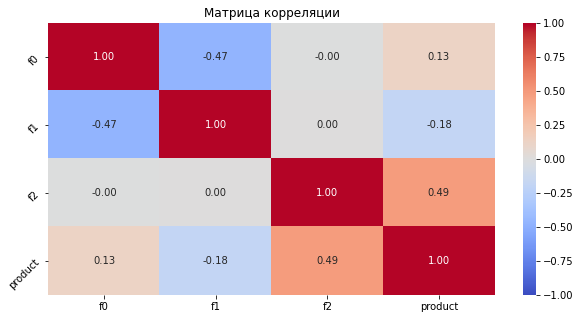

In [61]:
corr_matrix(c_data1, corr_num_columns, 'spearman', target=target)

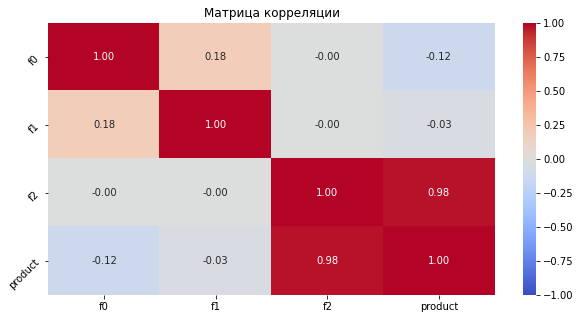

In [62]:
corr_matrix(c_data2, corr_num_columns, 'spearman', target=target)

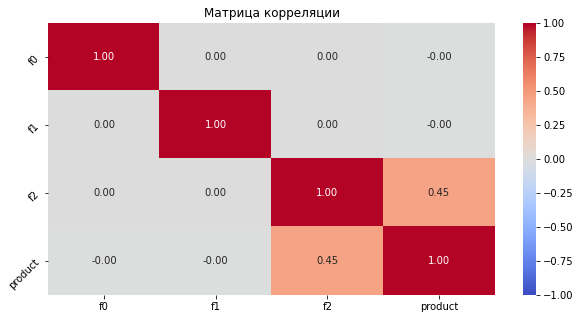

In [63]:
corr_matrix(c_data3, corr_num_columns, 'spearman', target=target)

- Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено. 
- При этом выявлена средняя обратная линейна зависимость между характеристиками f0 и f1 первого региона, а также слабая прямая зависимость между характеристиками f0 и f1 второго региона.
- Выявлена линейная зависимость различной степени между признаком f2 и объемом запасов.

Рассмотрим влияние входных признаков на целевой признак

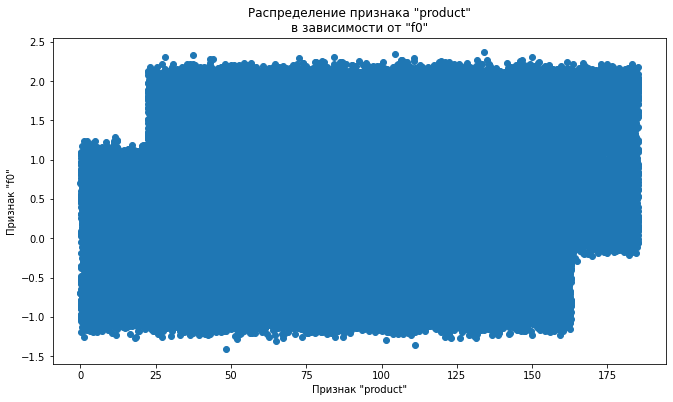

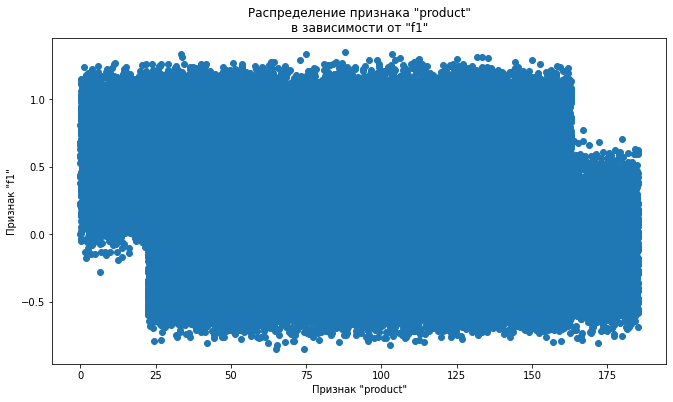

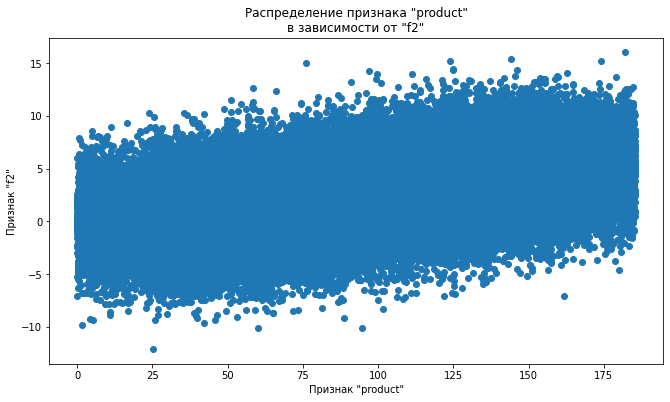

In [64]:
for item in corr_num_columns:
    numcat_scatter(c_data1, 'num', cols=[target,item])

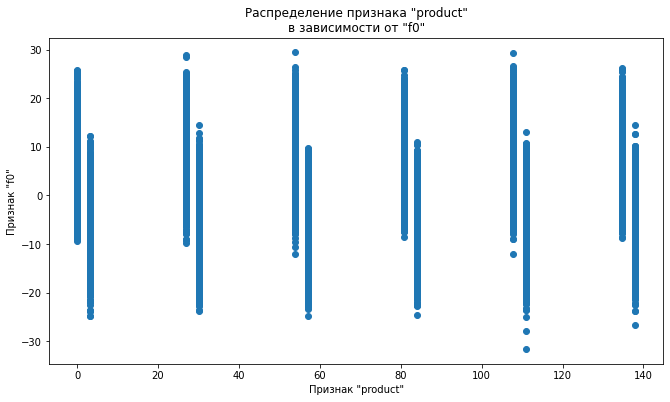

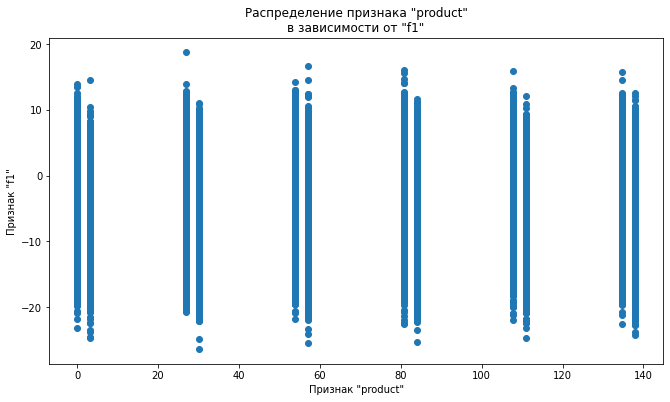

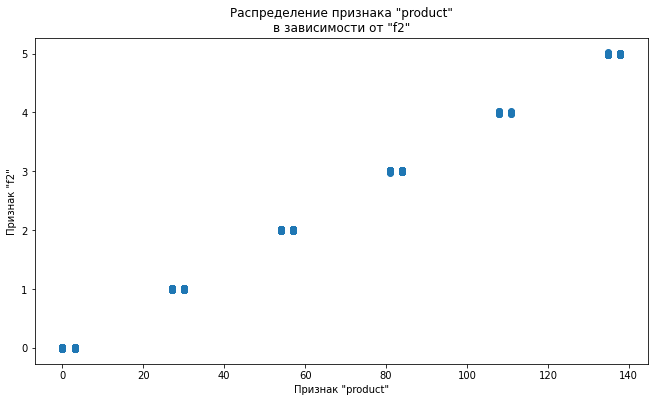

In [65]:
for item in corr_num_columns:
    numcat_scatter(c_data2, 'num', cols=[target,item])

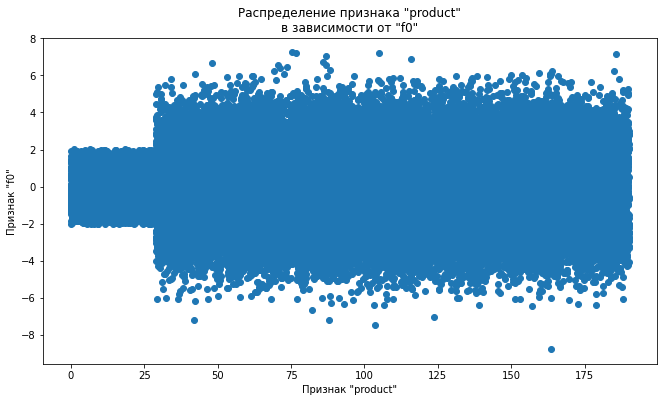

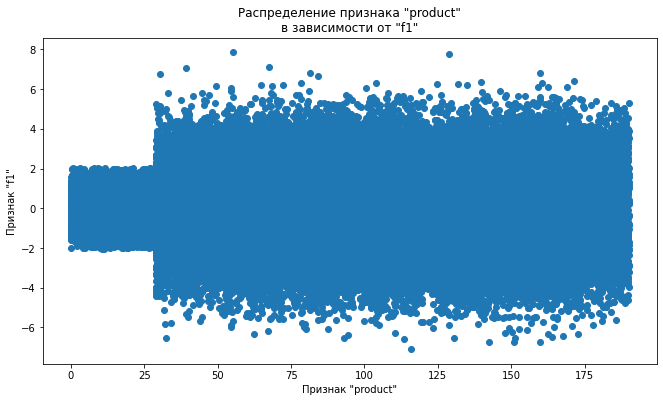

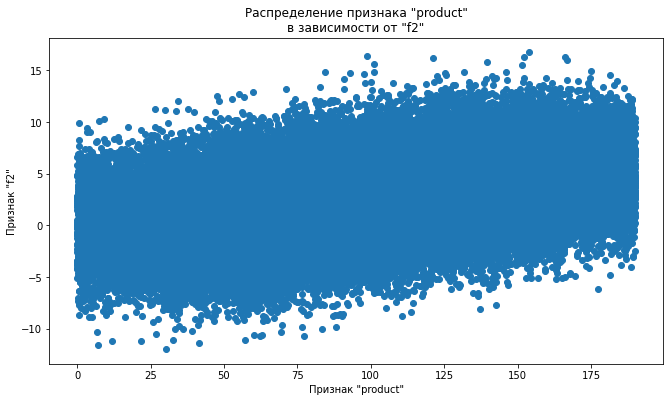

In [66]:
for item in corr_num_columns:
    numcat_scatter(c_data3, 'num', cols=[target,item])

_**Вывод**_

В результате корреляционного анализа:

- не выявлена сильная линейная связи (коэффициент корреляции от 0.9 и выше) между входными признаками. Мультиколлениарность не обнаружена.
- при этом, выявлена средняя обратная линейна зависимость между характеристиками f0 и f1 первого региона, а также слабая прямая зависимость между характеристиками f0 и f1 второго региона.
- выявлена линейная зависимость различной степени между признаком f2 и объемом запасов, в частности:
    - в первом и третьем регионах характеристика средне линейно влияет на объемы запасов;
    - во втором регионе характеристика очень сильно влияет на объемы запасов, при этом формируя аналог категориального целевого признака.

#### Вывод по разделу "Исследовательский анализ данных"

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

1. Во всех таблицах в ряде характеристик выявлены выбросы (не более 0.74%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.

2. Оценка распределений характеристик скважин.

    Характеристики f0 в различных регионах имеют различные показатели распределений (медианы очень различаются - 0.50, 1.15, 0.01, максимальные и минимальные значения также сильно различаются). Сравнивать скважины различных регионов нельзя, возможно, характеристики нефти очень различаются.  Аналогичная ситуация с характеристикой f1 (медианы очень различаются - 0.25, 4.84, 2.01). 
    
    Однако, по всем регионам обнаружена некоторая линейную зависимость между указанными характеристиками. При этом мультиколлениарность не обнаружена. 
    
    Характеристика f2 для второго региона выбивается из ряда аналогий, поскольку обобщенно носит категориальный характер (количественные значения сосредоточены вблизи 6 конкретных значений). В первои и третьем регионах характеристика средне линейно влияет на объемы запасов, а во втором регионе характеристика очень сильно влияет на объемы запасов, при этом формируя аналог категориального целевого признака.
    
    При этом, характеристики f0 и f1 влияют на объем запасов скважин нелинейно.
    
3. Все характеристики скважин представлены значениями близких порядков. Масштабирование данных представляется нецелесообразным. При этом, при обучении моделей попробуем применить различные способы масштабирования данных.

4. Считаем интересной разработку модели, которая будет предсказывать объем запасов скважин без привязки к регионам в целях разведки других регионов. Для этого необходимо учесть все возможные ситуации и обучить модель на консолидированных данных всех регионов. Проведем объединение данных при подготовке данных.  При этом, при консолидации могут быть обнаружены дубликаты по столбцу 'id'. Однако, в различных регионах могли повториться идентификаторы, созданные на базе ограниченного количества символов. Для нас это не важно, удалим столбец 'id'.

5. В то же время, обучим три отдельные модели для каждого региона. Затем сравним результаты.

### Шаг 4. Подготовка данных

В результате предыдущих шагов работы были определены ключевые действия по подготовке данных. Подготовим pipeline для обучения моделей с учетом указанных действий.

In [67]:
# Определим признаки
categorical_features = [
    
]

num_features = [
    'f0',
    'f1',
    'f2'
]

Подготовим загрузку pipeline

In [68]:
def load_pipe(
    model=None,
    num_scaler=None,
    ohe_columns=[],
    ord_columns=[],
    num_columns=[]):

    # создадим пайплайн для подготовки данных
    # со скэйлером для количественных столбцов
    data_preprocessor = ColumnTransformer(
        [
            ('num', num_scaler, num_columns)
        ], 
        remainder='passthrough'
    )
    
    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model)
        ]
    )
    
    return pipe_final

Подготовим выборки

In [69]:
X_train1, y_train1, X_test1, y_test1 = prepare_split(
    c_data1, 
    'product', 
    num_col_names=num_features,
    cat_col_names=[], 
    val=False
)
print(
    f"{X_train1.shape=}", 
    f"{y_train1.shape=}", 
    f"{X_test1.shape=}", 
    f"{y_test1.shape=}",
    sep='\n'
)

X_train1.shape=(74985, 3)
y_train1.shape=(74985,)
X_test1.shape=(24995, 3)
y_test1.shape=(24995,)


In [70]:
X_train2, y_train2, X_test2, y_test2 = prepare_split(
    c_data2, 
    'product', 
    num_col_names=num_features,
    cat_col_names=[], 
    val=False
)
print(
    f"{X_train2.shape=}", 
    f"{y_train2.shape=}", 
    f"{X_test2.shape=}", 
    f"{y_test2.shape=}",
    sep='\n'
)

X_train2.shape=(74994, 3)
y_train2.shape=(74994,)
X_test2.shape=(24998, 3)
y_test2.shape=(24998,)


In [71]:
X_train3, y_train3, X_test3, y_test3 = prepare_split(
    c_data3, 
    'product', 
    num_col_names=num_features,
    cat_col_names=[], 
    val=False
)
print(
    f"{X_train3.shape=}", 
    f"{y_train3.shape=}", 
    f"{X_test3.shape=}", 
    f"{y_test3.shape=}",
    sep='\n'
)

X_train3.shape=(74994, 3)
y_train3.shape=(74994,)
X_test3.shape=(24998, 3)
y_test3.shape=(24998,)


In [72]:
X_train0 = X_train1.merge(X_train2, how='outer')
X_train0 = X_train3.merge(X_train0, how='outer')
print(
    f"{X_train0.shape=}", 
    sep='\n'
)

X_train0.shape=(224973, 3)


In [73]:
y_train0 = pd.concat([y_train1, y_train2, y_train3])
print(
    f"{y_train0.shape=}", 
    sep='\n'
)

y_train0.shape=(224973,)


#### Вывод по разделу "Подготовка данных"

Пайплайн подготовлен с учетом методов обработки данных и неопределенных элементов в связи с их подборов на последующих этапах работы.
В ходе работы также подготовлены тренировочные и тестовые выборки для каждого региона, а также подготовлена тренировочная выборка для консолидированных данных. Тестовые выборки для каждого региона оставим те же.

### Шаг 5. Обучение моделей

Осуществим работу по обучению моделей.

Для работы выберем один алгоритм: линейную регрессии.

Для лучшей модели подберем скейлеры с использованием поиска по сетке (так как вариантов не много).
 
Критерий успеха в обучении моделей - показатель метрики RMSE: чем меньше, тем лучше.

В работе мы обучим три модели с данными одинакового масштаба, поэтому не обязательно использовать R2 для их сравнения. Тем более, что для нас важна ошибка в предсказании объемов запасов скважин, а в целом обобщающая способность моделей. В связи с этим, можно использовать метрики MAE и RMSE, которые еще и удобно измеряются в единицах наших данных.

Метрика МАЕ показывает характеристику аналогичную RMSE, но менее зависит от выбросов. В наших данных аномально больших выбросов не имеется, поэтому особой разницы в применении RMSE и MAЕ не наблюдается.

In [74]:
# создадим сетку параметров для подбора лучшей модели
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [
            'passthrough',
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            MaxAbsScaler(),
            Normalizer()
        ]  
    }
]

In [75]:
gs = GridSearchCV(
    load_pipe(
        model=None,
        num_scaler=None
    ), 
    param_grid, 
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

Обучать модель будем на различных входных данных регионам и по консолидированным данным.

In [76]:
X_train = [
    X_train0,
    X_train1,
    X_train2,
    X_train3
]

y_train = [
    y_train0,
    y_train1,
    y_train2,
    y_train3
]

In [77]:
results = []
for i in range(0, 4):
    gs.fit(X_train[i], y_train[i])
    result = {
        'region': i,
        'score': gs.best_score_ * (-1),
        'model': gs.best_estimator_,
    } 
    results.append(result)
results

[{'region': 0,
  'score': 46.78105966608339,
  'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num', 'passthrough', [])])),
                  ('models', LinearRegression())])},
 {'region': 1,
  'score': 37.67916066969373,
  'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num', 'passthrough', [])])),
                  ('models', LinearRegression())])},
 {'region': 2,
  'score': 0.8906830866409325,
  'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num', 'passthrough', [])])),
                  ('models', LinearRegression())])},
 {'region': 3,
  'score': 39.985402192251094,
  'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(remainder='pas

В целом, лучшей моделью признана модель без преобразования входных признаков: масштабирования или нормализации. Подтверждается вывод, сделанный в рамках ИАД.

Видим, что модель, обученная на данных второго региона предсказывает лучше всего (RMSE = 0.89). Вероятно, мы получили утечку целевого признака в связи с высокой линейной зависимостью целевого признака от характеристики f2 - подтверждаются выводы, сделанные в рамках ИАД.

Проверим метрики на тестовых данных нативных моделей по регионам, а также выведем средний запас предсказанного сырья.

In [78]:
X_test = [
    X_test1,
    X_test2,
    X_test3
]

y_test = [
    y_test1,
    y_test2,
    y_test3
]

In [79]:
results_prediction = []
for i in range(3):
    y_pred = results[i+1]['model'].predict(X_test[i])
    y_true = y_test[i].reset_index(drop=True)
    scores = mean_squared_error(y_true, y_pred, squared=False)
    mean_product = y_pred.mean()
    print(f"Изучаемый регион: {i+1} регион")
    print(f"RMSE модели на тестовых данных: {scores}")
    print(f"Средний запас предсказанного сырья в регионе: {mean_product}")
    print()
    result = {
        'region': i+1,
        'y_true': pd.Series(y_true),
        'y_pred': pd.Series(y_pred),
        'score': scores,
        'mean_product': mean_product
    }
    results_prediction.append(result)
results_prediction = pd.DataFrame(results_prediction)
results_prediction

Изучаемый регион: 1 регион
RMSE модели на тестовых данных: 37.739474181347475
Средний запас предсказанного сырья в регионе: 92.18934871188627

Изучаемый регион: 2 регион
RMSE модели на тестовых данных: 0.889626453450506
Средний запас предсказанного сырья в регионе: 68.50438116071928

Изучаемый регион: 3 регион
RMSE модели на тестовых данных: 40.262464354507394
Средний запас предсказанного сырья в регионе: 94.80325200019172



,region,y_true,y_pred,score,mean_product
0,1,0 123.732678 1 149.429323 2 ...,0 101.529616 1 93.459843 2 ...,37.739474,92.189349
1,2,0 107.813044 1 80.859783 2 ...,0 108.677591 1 82.229995 2 ...,0.889626,68.504381
2,3,0 96.464120 1 28.953178 2 ...,0 135.021846 1 56.787059 2 ...,40.262464,94.803252


Также наблюдаем, что модель второго региона предсказывает объем сырья лучше всего (RMSE = 0.89). Показатели моделей на тестовых данных очень близки к результатам на тренировочных данных.

Модель, обученная на консолидированных данных показала худшую метрику тренировочных данных. Интересно, как она будет работать на тестовых данных.

In [80]:
results_prediction_0 = []
for i in range(0, 3):
    y_pred = results[0]['model'].predict(X_test[i])
    result = {
        'region': i,
        'score': mean_squared_error(y_test[i], y_pred, squared=False)
    } 
    results_prediction_0.append(result)
results_prediction_0

[{'region': 0, 'score': 45.06456721180593},
 {'region': 1, 'score': 50.67610397559503},
 {'region': 2, 'score': 46.13683502817059}]

Показатели RMSE на тестовых данных в каждом регионе хуже нативных моделей. Однако, каждая их из них будет очевидно хуже работать в дургих регионах. При необходимости разведки новых регионов никакую из нативных моделей использовать нельзя.

#### Вывод по разделу "Обучение моделей"

В результате проведенной работы по обучению моделей достигнуты следующие результаты:
1. Для работы выбран один алгоритм: линейная регрессии.
2. С использованием пайплайнов и автоматизированного поиска с кросс-валидацией найдены лучшие модели для каждого региона и консолидированных данных. Перебирались различные способы масшабирования и нормализации входных признаков. 
3. Для всех регионов и консолидированных данный _лучшей признана модель линейной регрессии без масштабирования (подтверждается предположение, сделанное в ИАД)_.
4. Исследуемые метрики RMSE моделей регионов на тренировочных данных следующие:
    - 1 регион - 37.68;
    - 2 регион - 0.89;
    - 3 регоин - 39.99;
    - консолидированные данные - 46.79.
5. Выявлено, что модель второго региона предсказывает лучше всего (RMSE = 0.89). Нами _получена утечка целевого признака в связи с высокой линейной зависимостью целевого признака от характеристики f2 (подтверждаются выводы, сделанные в рамках ИАД)_.
6. Результаты обучения хуже для модели, обученной на консолидированных данных.
7. Исследуемые метрики RMSE моделей регионов на _тестовых_ данных следующие:
    - 1 регион - 37.74;
    - 2 регион - 0.89;
    - 3 регоин - 40.26.
8. Результаты предсказаний моделей сохранены в отдельную таблицу для дальнейшей работы.
9. Выявлены следующие показатели среднего предсказанного объема запасов скважин в каждом регионе:
    - 1 регион - 92.19 тыс. баррелей;
    - 2 регион - 68.50 тыс. баррелей;
    - 3 регоин - 94.80 тыс. баррелей.
10. Модель, обученная на консолидированных данных показала худшую метрику тренировочных данных. Показатели RMSE на тестовых данных в каждом регионе хуже нативных моделей. Однако, каждая их из них будет очевидно хуже работать в дургих регионах. При необходимости разведки новых регионов никакую из нативных моделей использовать нельзя.

## Оценка прибыли и рисков убытков для представленных регионов

### Шаг 1. Расчет достаточного объёма сырья для безубыточной разработки новой скважины

Сохраним все ключевые значения для расчетов в отдельных переменных. Все финансовые показатели будем рассматривать в миллионах рублей.

In [81]:
n_oil_well = 500
best_n_oil_well = 200
investments = 10_000_000_000 / 1_000_000
revenue_per_product = 450_000 / 1_000_000
odd = 0.025

Инвестиции на разработку одной скважины в условиях выбора 200 лучших скважин в регионе составляют 50 млн рублей:

In [82]:
investments_per_well = investments / best_n_oil_well
investments_per_well

50.0

Прибыль с одной скважины должна быть не меньше инвестиций. Следовательно, безубыточной разработка новой скважины будет, если объем запасов скважины составит не менее 111 тыс. баррелей:

In [83]:
min_product = investments_per_well / revenue_per_product
round(min_product, 2)

111.11

Сравним со средним предсказанным объемом запасом скважин в каждом регионе.

In [84]:
results_prediction[['region', 'mean_product']]

,region,mean_product
0,1,92.189349
1,2,68.504381
2,3,94.803252


In [85]:
results_prediction['good_wells'] = (
    round(
        results_prediction['y_pred']
        .apply(lambda x: len([i for i, x in enumerate(x) if x > min_product])),
        2
    )
)
results_prediction[['region', 'mean_product', 'good_wells']]

,region,mean_product,good_wells
0,1,92.189349,5237
1,2,68.504381,4522
2,3,94.803252,5255


Во всех регионах среднее значение объема запасов скважин ниже необходимого для безубыточной разработки. При этом, в регионах необходимо выбрать лучшие скважины. Попробуем оценить возможность возврата инвестиций и получения прибыли для 200 лучших скважин среди исследованных 500.

#### Вывод по шагу 1

В результате проведенной работы по подготовке к расчету финансовых показателей достигнуты следующие результаты:
1. Определены ключевые исходные данные из условия задачи, а также определен объем инвестиций на разработку одной скважины.
2. С учетом предыдущего шага выявлен минимально необходимый объем запасов скважины для обеспечения безубыточной ее разработки - не менее 111 тыс. баррелей. 
3. В предыдущей части работы для каждого региона были предсказаны объемы запасов скважин. Изучив значения этого показателя и его среднее сделаны следующие выводы:
    - во всех регионах среднее значение объема запасов скважин ниже минимально необходимого;
    - при этом во всех регионах достаточно скважин с объемом запасов выше минимально необходимого:
        - 1 регион - 5237 скважин;
        - 2 регион - 4522 скважин;
        - 3 регоин - 5255 скважин.
4. В регионах могут быть исследованы только 500 скважин. Попробуем оценить возможность возврата инвестиций и получения прибыли  среди исследованных 500 скважин для 200 лучших скважин, предсказанных нашими моделями.

### Шаг 2. Разработка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели.

Для оценки  возможность возврата инвестиций и получения прибыли от эксплуатации скважин разработаем функцию расчета прибыли для применения техники Bootstrap.

В функции из входного массива предсказанных объемов запасов скважин (predictions) будет сформирован отсортированный массив по убыванию и выбраны 200 лучших скважин. Из второго входного массива истинных объемов запасов скважин (poducts) будут выбраны скважины, соответсвующие 200 лучшим по мнению нашей модели. 

Вернет функция значение прибыли, которую можно выручить после разработки этих скважин:
- просуммируем значение объёма сырья, соответствующее скважинам;
- умножим сумму объема сырья на выручку от одной тысячи баррелей (revenue_per_product);
- вычтем инвестиции на разработку скважин, как произведение количества скважин (count) на инвестции на разработку одной скважина (investments_per_well).

In [86]:
def revenue(predictions, products, count):
    products_sorted = predictions.sort_values(ascending=False)    
    selected = products[products_sorted.index][:count]
    res = (
        sum(selected) 
        * revenue_per_product 
        - count*investments_per_well
    )
    return res

Для удобства работы с тремя регионами будем продолжать заполнять результирующую таблицу.

In [87]:
results_prediction

,region,y_true,y_pred,score,mean_product,good_wells
0,1,0 123.732678 1 149.429323 2 ...,0 101.529616 1 93.459843 2 ...,37.739474,92.189349,5237
1,2,0 107.813044 1 80.859783 2 ...,0 108.677591 1 82.229995 2 ...,0.889626,68.504381,4522
2,3,0 96.464120 1 28.953178 2 ...,0 135.021846 1 56.787059 2 ...,40.262464,94.803252,5255


Дополнительно оценим прибыль от разработки 200 лучших скважин (по мнению модели) в каждом регионе.

In [88]:
results_prediction['revenue_best200'] = (
    round(
        results_prediction
        .apply(lambda x: revenue(x['y_pred'], x['y_true'], 200), axis=1),
        2
    )
)
results_prediction[['region', 'revenue_best200']]

,region,revenue_best200
0,1,3147.07
1,2,2415.09
2,3,2814.89


Во всех регионах 200 лучших скважин показывают значительную прибыль. Для удобной оценки рассчитаем ROI.

In [89]:
results_prediction['best200_ROI'] = (
    round(
        results_prediction['revenue_best200']
        .apply(lambda x: x / investments),
        2
    )
)
results_prediction[['region', 'revenue_best200', 'best200_ROI']]

,region,revenue_best200,best200_ROI
0,1,3147.07,0.31
1,2,2415.09,0.24
2,3,2814.89,0.28


#### Вывод по шагу 2

В результате проведенной работы достигнуты следующие результаты:
1. Разработана функция расчета прибыли, которую можно получить после разработки 200 предсказанных скважин, на основании истинных значений.
2. Для проверки работы функции расчитана прибыль от реализации 200 лучших скважин (по мнению модели) в каждом регионе.
3. Во всех регионах 200 лучших скважин показывают значительную прибыль и ROI:
    - 1 регион - 3 147 млн баррелей, ROI - 31%;
    - 2 регион - 2 415 млн баррелей, ROI - 24%;
    - 3 регоин - 2 815 млн баррелей, ROI - 28%.

### Шаг 3. Расчет рисков и прибыли для каждого региона.

Однако, в каждом регионе могут быть исследованы случайно только 500 точек. Не факт, что в их состав попадут лучшие 200 скважин региона и дадут такой показатель рентабельности. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

Для работы с различными регионами создадим функцию bootstrap.

In [90]:
def bootstrap(predictions, products, full_count, best_count, steps):
    values = []
    state = np.random.RandomState(0)
    for i in range(steps):
        target = predictions.sample(
            n=full_count,
            replace=True,
            random_state=state
        )
        values.append(revenue(target, products, best_count))
    return values

Определим основные условия задачи

In [91]:
predictions = results_prediction.loc[0, 'y_pred']
products = results_prediction.loc[0, 'y_true']
full_count = 500
best_count = 200
steps = 1000

Выполним расчет техникой Bootstrap

In [92]:
results_prediction['rev_200from500'] = (
    results_prediction
    .apply(
        lambda x: bootstrap(
            x['y_pred'],
            x['y_true'],
            full_count, 
            best_count, steps
        ),
        axis=1
    )
)

Вычислим среднее значение прибыли от разработки 200 лучших скважин из 500 случайно исследованных

In [93]:
results_prediction['mean_rev_200from500'] = (
    round(
        results_prediction['rev_200from500']
        .apply(lambda x: pd.Series(x).mean()),
        2
    )
)

results_prediction[['region', 'mean_rev_200from500']]

,region,mean_rev_200from500
0,1,421.24
1,2,413.31
2,3,308.12


Вычислим 95%-й доверительный интервал на освании 0.025 и 0.975 процентилей распределения прибыли от разработки скважин.

In [94]:
results_prediction['confidence_interval_lower'] = (
    round(
        results_prediction['rev_200from500']
        .apply(lambda x: pd.Series(x).quantile(0.025)),
        2
    )
)

results_prediction['confidence_interval_upper'] = (
    round(
        results_prediction['rev_200from500']
        .apply(lambda x: pd.Series(x).quantile(0.975)),
        2
    )
)

results_prediction[
    [
        'region',
        'mean_rev_200from500',
        'confidence_interval_lower', 
        'confidence_interval_upper'
    ]
]

,region,mean_rev_200from500,confidence_interval_lower,confidence_interval_upper
0,1,421.24,-88.89,906.07
1,2,413.31,35.38,811.61
2,3,308.12,-224.42,812.79


Вычислим риск получения убыткой. Посчитаем отношение количества убыточных выборок пятисот скважин для исследования и двухсот скважин с предсказанным объем к общему количеству выборок (1000 выборок).

In [95]:
results_prediction['loss_rate'] = (
    results_prediction['rev_200from500']
    .apply(lambda x: len([i for i, x in enumerate(x) if x < 0]) / len(x))
)

results_prediction[
    [
        'region',
        'mean_rev_200from500',
        'confidence_interval_lower', 
        'confidence_interval_upper',
        'loss_rate'
    ]
]

,region,mean_rev_200from500,confidence_interval_lower,confidence_interval_upper,loss_rate
0,1,421.24,-88.89,906.07,0.053
1,2,413.31,35.38,811.61,0.013
2,3,308.12,-224.42,812.79,0.136


Выведем результаты расчетов предыдущих расчетов для анализа по каждому региону.

In [96]:
results_prediction['rev_200from500'].apply(lambda x: (pd.Series(x) < 0).mean())

0    0.053
1    0.013
2    0.136
Name: rev_200from500, dtype: float64

In [97]:
for i in range(3):
    print(f"Ключевые показатели разработки {i+1}-го региона:")
    print(
        f"--> Прибыль от разработки 200 лучших скважин региона: "
        f"{results_prediction.loc[i, 'revenue_best200']:,} млн рублей."
    )
    print(
        f"--> Средняя прибыль от разработки 200 лучших скважин "
        f"из 500 случайно исследованных: "
        f"{results_prediction.loc[i, 'mean_rev_200from500']} млн рублей."
    )
    print(
        f"----> 95%-й доверительный интервал прибыли: "
        f"от {results_prediction.loc[i, 'confidence_interval_lower']} "
        f"до {results_prediction.loc[i, 'confidence_interval_upper']} "
        f"млн рублей."
    )
    print(
        f"----> Минимальное значение прибыли: "
        f"{round(min(results_prediction.loc[i, 'rev_200from500']), 2)} "
        f"млн рублей."
    )
    print(
        f"----> Максимальное значение прибыли: "
        f"{round(max(results_prediction.loc[i, 'rev_200from500']), 2)} "
        f"млн рублей."
    )
    print(
        f"----> Риск убытков: "
        f"{round(results_prediction.loc[i, 'loss_rate']*100,3)}%"
    )
    print()

Ключевые показатели разработки 1-го региона:
--> Прибыль от разработки 200 лучших скважин региона: 3,147.07 млн рублей.
--> Средняя прибыль от разработки 200 лучших скважин из 500 случайно исследованных: 421.24 млн рублей.
----> 95%-й доверительный интервал прибыли: от -88.89 до 906.07 млн рублей.
----> Минимальное значение прибыли: -422.94 млн рублей.
----> Максимальное значение прибыли: 1383.9 млн рублей.
----> Риск убытков: 5.3%

Ключевые показатели разработки 2-го региона:
--> Прибыль от разработки 200 лучших скважин региона: 2,415.09 млн рублей.
--> Средняя прибыль от разработки 200 лучших скважин из 500 случайно исследованных: 413.31 млн рублей.
----> 95%-й доверительный интервал прибыли: от 35.38 до 811.61 млн рублей.
----> Минимальное значение прибыли: -287.19 млн рублей.
----> Максимальное значение прибыли: 1039.91 млн рублей.
----> Риск убытков: 1.3%

Ключевые показатели разработки 3-го региона:
--> Прибыль от разработки 200 лучших скважин региона: 2,814.89 млн рублей.
--> Ср

Визуализируем распределения прибыли по каждому региону для презентации.

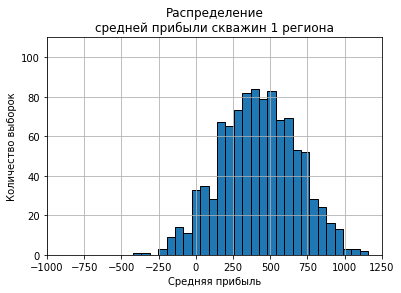

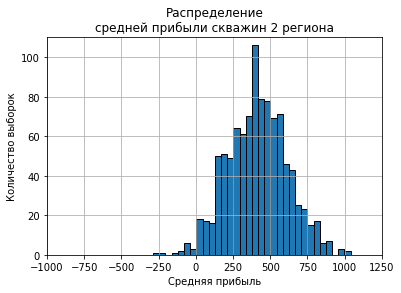

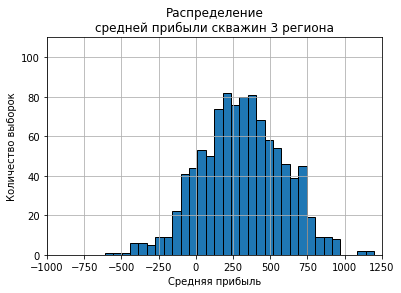

In [98]:
for i in range(3):
    data = results_prediction.loc[i, 'rev_200from500']
    bins = int(np.round(math.sqrt(len(data)), 0))
    (
        pd.Series(data)
        .plot(kind='hist', bins=bins, grid=True, legend=False, edgecolor='black')
    )
    plt.title(f"Распределение\nсредней прибыли скважин {i+1} региона")
    plt.xlabel("Средняя прибыль")
    plt.ylabel("Количество выборок")
    plt.xlim(-1000, 1250)
    plt.ylim(0, 110)
    plt.show() 

Представим распределение прибыли по всем  регионам на одном графике в относительных значениях.

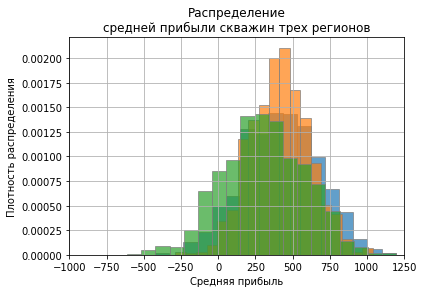

In [99]:
for i in range(3):
    data = results_prediction.loc[i, 'rev_200from500']
    (
        pd.Series(data)
        .hist(bins=19, grid=True, legend=False, density=True, alpha=0.7, edgecolor='grey')
    )
plt.title(f"Распределение\nсредней прибыли скважин трех регионов")
plt.xlabel("Средняя прибыль")
plt.ylabel("Плотность распределения")
plt.xlim(-1000, 1250)
plt.show() 

Проверим нормальность распределения прибыли от разработки скважин.

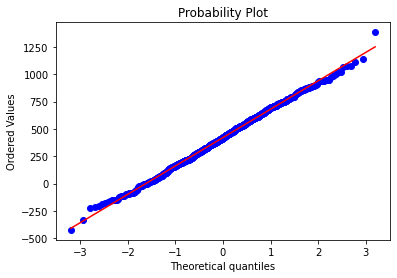

p-value = 0.4413758803767339. Имеются основания говоритьо нормальности распределения


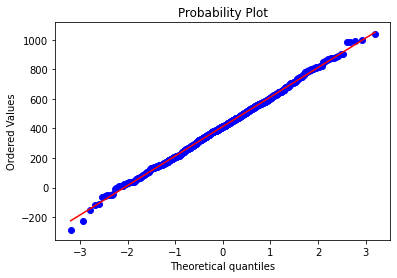

p-value = 0.8318057373491753. Имеются основания говоритьо нормальности распределения


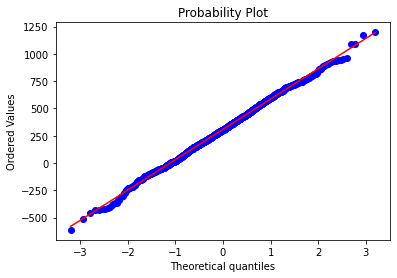

p-value = 0.8446654915458426. Имеются основания говоритьо нормальности распределения


In [100]:
for i in range(3):
    print(is_norm(results_prediction.loc[i, 'rev_200from500']))

#### Вывод по шагу 3

В результате проведенной работы достигнуты следующие результаты:
1. Техникой Bootstrap осуществлена оценка распределения прибыли от разработки 200 лучших скважин из 500 случайно исследованных скважин в зависимости от выборки пятисот скважин с учетом качества разработанной нами модели.
2. Имеются основания говорить о нормальности указанных распределений.
3. Расчитаны средняя прибыль от разработки скважин, 95%-й доверительный интервал прибыли и существующие риски получения убытков:
    - для первого региона:
        - средняя прибыль - 421.24 млн рублей;
        - 95%-й доверительный интервал прибыли: от -88.89 до 906.07 млн рублей;
        - риск убытков: 5.3%.
    - для второго региона:
        - средняя прибыль - 413.31 млн рублей;
        - 95%-й доверительный интервал прибыли: от 35.38 до 811.61 млн рублей;
        - риск убытков: 1.3%.
    - для третьего региона:
        - средняя прибыль - 308.12 млн рублей;
        - 95%-й доверительный интервал прибыли: от -224.42 до 812.79 млн рублей;
        - риск убытков: 13.6%.
4. С учетом полученных значений выявлено:
    - лучшая средняя прибыль достигается в первом регионе;
    - 95% выборок скважин для исследования обеспечивают исключительно прибыль только во втором регионе;
    - риск убытков удовлетворяет условию заказчика (меньше 2,5%) только во втором регионе.
    - во втором регионе средняя прибыль чуть меньше первого региона.
5. С связи с изложенным, предлагается осуществить разработку скважин _во втором регионе_.

## Итоговый вывод

В соответствии с планом работы были достигнуты следующие результаты.

**А. Изучение входных данных**

Для проведения исследования была полученые выборки из 300_000 записей с пробами нефти в трех регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Все сведения представлены в 3 таблицах с полями: id — уникальный идентификатор скважины; f0, f1, f2 — ключевые признаки скважин; product — объём запасов в скважине (тыс. баррелей).

Можно сделать _предварительный_ вывод, что предоставленных данных достаточно для достижения цели исследования. Явных проблем с входными данными, требующих предобработки, не выявлено. Сделаны предположения о наличии дубликатов.

**Б. Предобработка данных**

В ходе предобработки данных они были проанализированы на наличие дубликатов. Были обнаружены дубликаты по столбцу `id`. Несколько скваждин продублированы с различными показателями. Мы не знаем, какие показатели правильные. Количество дубликатов очень мало. При этом, такие дубликаты найдены во всех таблицах. Все записи были удалены.

Предобработка данных завершена, данные готовы к дальнейшей анализу.

**В. Результаты исследовательского анализа**

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

1. Во всех таблицах в ряде характеристик выявлены выбросы (не более 0.74%), но не были удалены, поскольку похожи на нормальные значения. Без эксперта в предметной области принять решение об удалении выбросов нельзя.

2. Произведена оценка распределений характеристик скважин и корелляционный анализ.

    Характеристики f0 в различных регионах имеют различные показатели распределений (медианы очень различаются - 0.50, 1.15, 0.01, максимальные и минимальные значения также сильно различаются). Сравнивать скважины различных регионов нельзя, возможно, характеристики нефти очень различаются.  Аналогичная ситуация с характеристикой f1 (медианы очень различаются - 0.25, 4.84, 2.01). 
    
    Однако, по всем регионам обнаружена некоторая линейную зависимость между указанными характеристиками. При этом мультиколлениарность не обнаружена. 
    
    Характеристика f2 для второго региона выбивается из ряда аналогий, поскольку обобщенно носит категориальный характер (количественные значения сосредоточены вблизи 6 конкретных значений). В первои и третьем регионах характеристика средне линейно влияет на объемы запасов, а во втором регионе характеристика очень сильно влияет на объемы запасов, при этом формируя аналог категориального целевого признака.
    
    При этом, характеристики f0 и f1 влияют на объем запасов скважин нелинейно.
    
    Все характеристики скважин представлены значениями близких порядков. Масштабирование данных представляется нецелесообразным. При этом, при обучении моделей попробуем применить различные способы масштабирования данных.

    Для каждого региона принято решение обучить свою (нативную) модель. Затем сравним результаты.
    
    При этом, приняторешение произвести разработку модели, которая будет предсказывать объем запасов скважин без привязки к регионам в целях разведки других регионов. Для этого необходимо учесть все возможные ситуации и обучить модель на консолидированных данных всех регионов.
    
**Г. Подготовка данных**

Для дальнейшего обучения моделей МО выполнены следующие работы:
- разработаны средства автоматизации процесса обучения моделей (pipeline) с учетом результатов предобработки данных;
- подготовлены выборки для обучения моделей по каждому региону и консолидированная выборка. Все данные разделены в соотношении 75% тренировочной выборки к 25% тестовой выборки.

**Д. Разработка моделей машинного обучения**

В результате проведенной работы по обучению моделей достигнуты следующие результаты:
1. Для работы выбран один алгоритм: линейная регрессии. С использованием пайплайнов и автоматизированного поиска с кросс-валидацией найдены лучшие модели для каждого региона и консолидированных данных. Перебирались различные способы масшабирования и нормализации входных признаков. 
2. Для всех регионов и консолидированных данный _**лучшей признана модель линейной регрессии без масштабирования (подтверждается предположение, сделанное в ИАД)**_.
3. Выявлено, что модель второго региона предсказывает лучше всего (RMSE = 0.89). _**Получена утечка целевого признака в связи с высокой линейной зависимостью целевого признака от характеристики f2 (подтверждаются выводы, сделанные в рамках ИАД)**_.
4. Исследуемые метрики RMSE моделей регионов на _тестовых_ данных следующие:
    - 1 регион - 37.74;
    - 2 регион - 0.89;
    - 3 регоин - 40.26.
5. Выявлены следующие показатели среднего предсказанного объема запасов скважин в каждом регионе:
    - 1 регион - 92.19 тыс. баррелей;
    - 2 регион - 68.50 тыс. баррелей;
    - 3 регоин - 94.80 тыс. баррелей.
6. Модель, обученная на консолидированных данных показала худшую метрику тренировочных данных. Показатели RMSE на тестовых данных в каждом регионе хуже нативных моделей. Однако, каждая их из них будет очевидно хуже работать в дургих регионах. При необходимости разведки новых регионов никакую из нативных моделей использовать нельзя.

**Е. Оценка прибыли и рисков убытков для представленных регионов**

В результате проведенной работы:
1. Проведена подготовка к расчету финансовых показателей: определены ключевые исходные данные из условия задачи, определен объем инвестиций на разработку одной скважины, выявлен **минимально необходимый объем запасов скважины для обеспечения безубыточной ее разработки - не менее 111 тыс. баррелей**. Изучив значения этого показателя результаты предсказаний моделей МО сделаны следующие выводы:
    - во всех регионах среднее значение объема запасов скважин ниже минимально необходимого;
    - при этом во всех регионах достаточно скважин с объемом запасов выше минимально необходимого.
2. В регионах могут быть исследованы только 500 скважин. В работе проведена оценка возможности возврата инвестиций и получения прибыли среди исследованных 500 скважин для 200 лучших скважин, предсказанных нашими моделями:
    - расчитана прибыль от реализации 200 лучших скважин (по мнению моделей МО) в каждом регионе:
        - 1 регион - 3 147 млн баррелей, ROI - 31%;
        - 2 регион - 2 415 млн баррелей, ROI - 24%;
        - 3 регоин - 2 815 млн баррелей, ROI - 28%.
3. Техникой Bootstrap осуществлена оценка распределения прибыли от разработки 200 лучших скважин из 500 случайно исследованных скважин в зависимости от выборки пятисот скважин с учетом качества разработанной нами модели. Расчитаны средняя прибыль от разработки скважин, 95%-й доверительный интервал прибыли и существующие риски получения убытков:
    - для первого региона:
        - средняя прибыль - 421.24 млн рублей;
        - 95%-й доверительный интервал прибыли: от -88.89 до 906.07 млн рублей;
        - риск убытков: 5.3%.
    - для второго региона:
        - средняя прибыль - 413.31 млн рублей;
        - 95%-й доверительный интервал прибыли: от 35.38 до 811.61 млн рублей;
        - риск убытков: 1.3%.
    - для третьего региона:
        - средняя прибыль - 308.12 млн рублей;
        - 95%-й доверительный интервал прибыли: от -224.42 до 812.79 млн рублей;
        - риск убытков: 13.6%.
4. Имеются основания говорить о нормальности указанных распределений.
5. С учетом полученных результатов выявлено:
    - лучшая средняя прибыль достигается в первом регионе;
    - 95% выборок скважин для исследования обеспечивают исключительно прибыль только во втором регионе;
    - риск убытков удовлетворяет условию заказчика (меньше 2,5%) только во втором регионе.
    - во втором регионе средняя прибыль чуть меньше первого региона.
6. **С связи с изложенным, предлагается осуществить разработку скважин _во втором регионе_.**

**Е. Достижение цели работы**

Построена модель МО, которая предскажет регион, где добыча нефты принесет наибольшую прибыль. В частности, модель МО для второго региона показывает перспективность разработки указанного региона.

**Рекомендации бизнесу (дальнейшая работа)**
В результате работы выявлено, что нативные модели достаточно хорошо предсказывают объем запасов скважин в каждом регионе и позволяют оценить перспективность разработки скважин в регионе. В то же время предсказание объемов запасов скважин в других регионах (например, новых) на нативных моделях даст очевидно не самый лучший результат. В связи с этим, предлагается продолжить анализ модели, обученной на консолидированных данных. 